Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 30 CSV files


/tmp/ipython-input-3-3551359902.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
/tmp/ipython-input-3-3551359902.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)


Combined shape: (3284, 14)


/tmp/ipython-input-3-3551359902.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = combined_df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/5b2k0xh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/dxbhqhvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65398', 'data', 'file=/tmp/tmprdqotoif/5b2k0xh9.json', 'init=/tmp/tmprdqotoif/dxbhq

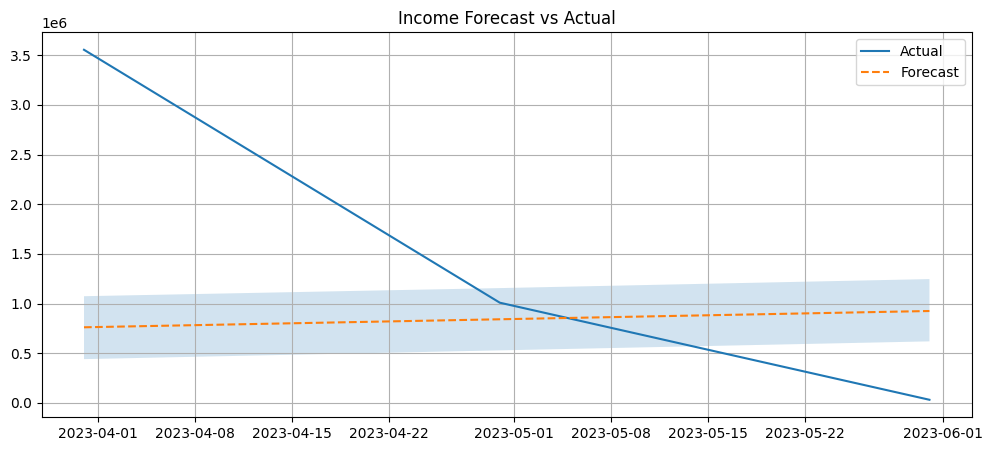

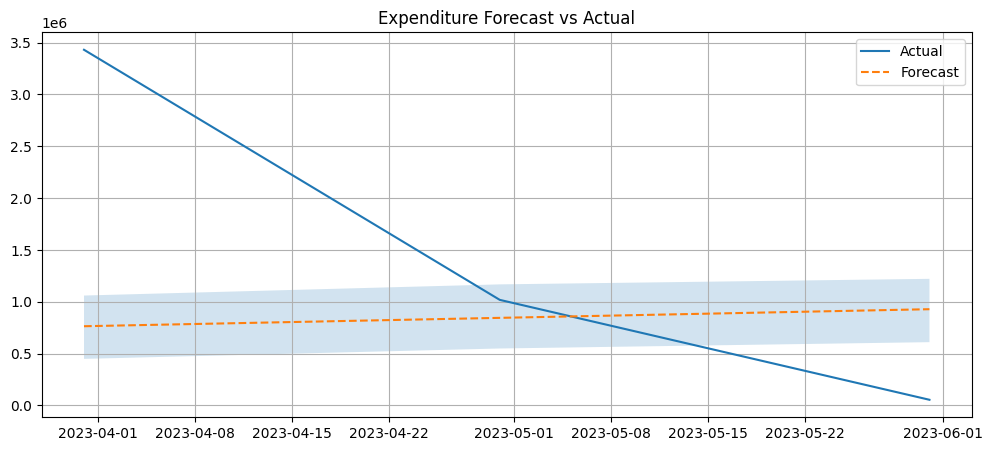

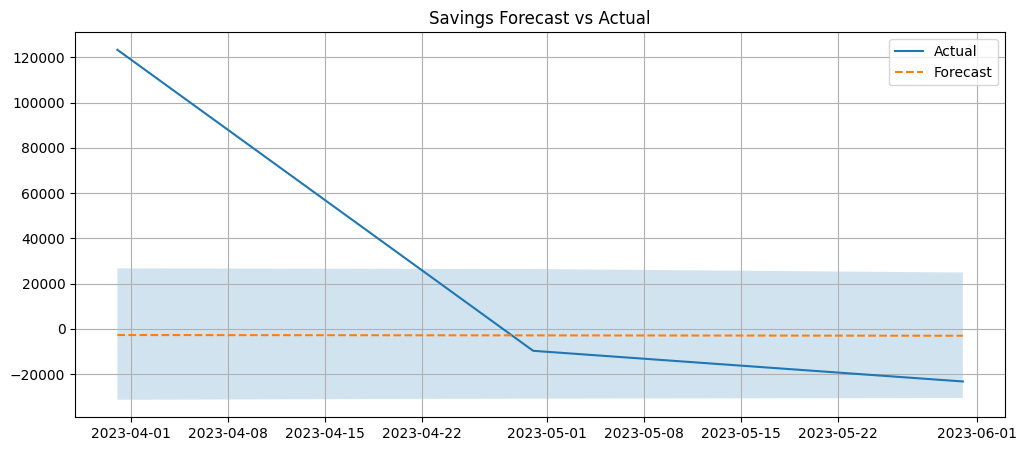

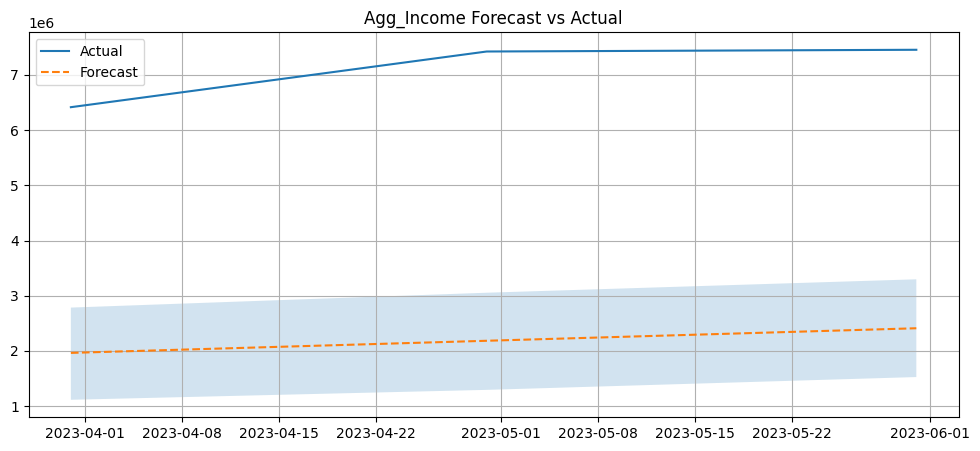

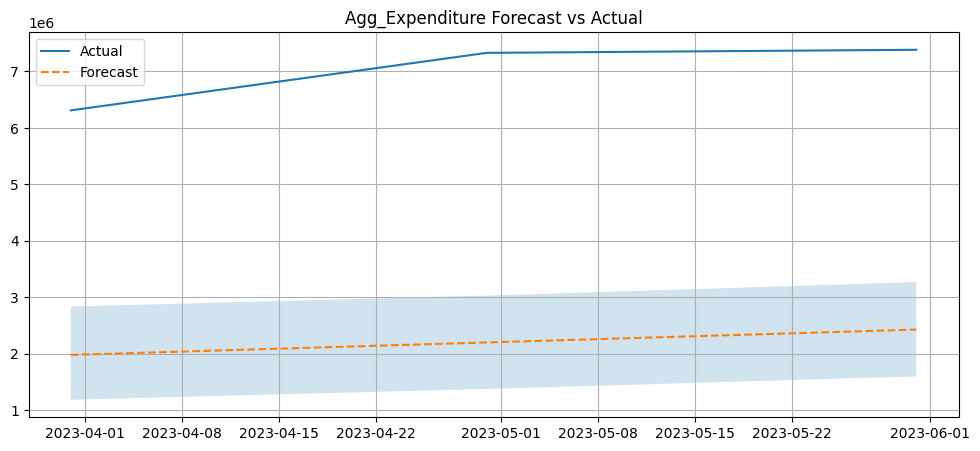

Income Forecast Evaluation:
RMSE: 1696177.91
MAE: 1284778.52
MAPE: 982.54%
Expenditure Forecast Evaluation:
RMSE: 1623501.01
MAE: 1238141.28
MAPE: 564.65%
Savings Forecast Evaluation:
RMSE: 73873.95
MAE: 51071.88
MAPE: 86.34%
Classification Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



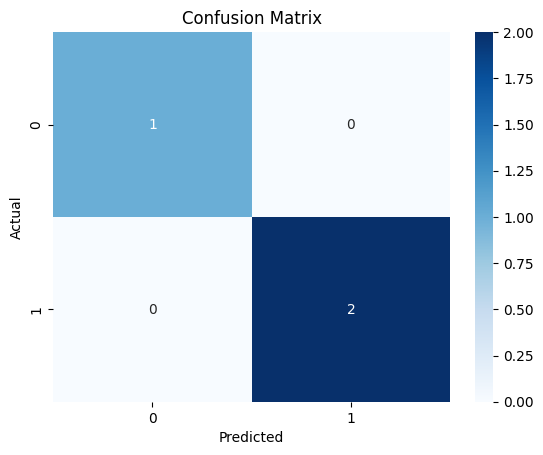

In [ ]:
# ✅ CELL 1: Mount Google Drive and Read Folder Directly
from google.colab import drive
import glob
import os

# Mount the Google Drive to access dataset folder
drive.mount('/content/drive')

# Set your folder path containing the bank transaction CSV files
data_folder = 'data/bank_transactions'

# Get all CSV files from the folder
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))
print(f"Found {len(csv_files)} CSV files")

# Preview few file names
csv_files[:3]


# ✅ CELL 2: Preprocess and Combine All CSVs with Extended Feature Engineering
import pandas as pd
import numpy as np

def preprocess_bank_statement(filepath):
    df = pd.read_csv(filepath)

    # Clean date format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
    df = df.dropna(subset=['Date'])

    # Clean amount column (force to numeric)
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df.dropna(subset=['Amount', 'Debit/Credit'], inplace=True)

    # Fill missing Entities and Mode
    df['Entities'] = df['Entities'].fillna(f"Unknown_{np.random.randint(1, 1000)}")
    df['Mode'] = df['Mode'].fillna(f"Unknown_{np.random.randint(1, 1000)}")

    df = df.sort_values('Date')

    # Income and Expenditure split
    df['Income'] = df.apply(lambda row: row['Amount'] if str(row['Debit/Credit']).strip().lower() == 'credit' else 0, axis=1)
    df['Expenditure'] = df.apply(lambda row: row['Amount'] if str(row['Debit/Credit']).strip().lower() == 'debit' else 0, axis=1)

    df['Savings'] = df['Income'] - df['Expenditure']
    df['Days_Since_Last'] = df['Date'].diff().dt.days.fillna(0).astype(int)

    return df


combined_df = pd.concat([preprocess_bank_statement(f) for f in csv_files], ignore_index=True)
combined_df = combined_df.sort_values("Date").reset_index(drop=True)
print("Combined shape:", combined_df.shape)
combined_df.head()


# ✅ CELL 3: Monthly Aggregation with Advanced Features
monthly_df = combined_df.groupby(pd.Grouper(key='Date', freq='M')).agg({
    'Income': 'sum',
    'Expenditure': 'sum',
    'Savings': 'sum',
    'Amount': ['count', 'mean', 'std'],
    'Days_Since_Last': 'mean'
}).reset_index()

monthly_df.columns = ['Date', 'Income', 'Expenditure', 'Savings',
                      'Transaction_Count', 'Avg_Transaction', 'Volatility', 'Avg_Gap']

monthly_df['Agg_Income'] = monthly_df['Income'].cumsum()
monthly_df['Agg_Expenditure'] = monthly_df['Expenditure'].cumsum()
monthly_df['Month'] = monthly_df['Date'].dt.month
monthly_df['Month_sin'] = np.sin(2 * np.pi * monthly_df['Month'] / 12)
monthly_df['Month_cos'] = np.cos(2 * np.pi * monthly_df['Month'] / 12)
monthly_df = monthly_df.dropna()
monthly_df.head()


# ✅ CELL 4: Prophet Forecasting with Explicit Train-Test Split
from prophet import Prophet

def forecast_with_split(df, col_name, test_size=0.2):
    ts = df[['Date', col_name]].rename(columns={'Date': 'ds', col_name: 'y'})
    split_idx = int(len(ts) * (1 - test_size))
    train_ts = ts.iloc[:split_idx]
    test_ts = ts.iloc[split_idx:]

    model = Prophet()
    model.fit(train_ts)

    future = model.make_future_dataframe(periods=len(test_ts), freq='M', include_history=False)
    forecast = model.predict(future)
    forecast['actual'] = test_ts['y'].values

    return model, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actual']]

model_income, forecast_income = forecast_with_split(monthly_df, 'Income')
model_expenditure, forecast_expenditure = forecast_with_split(monthly_df, 'Expenditure')
model_savings, forecast_savings = forecast_with_split(monthly_df, 'Savings')
model_agg_income, forecast_agg_income = forecast_with_split(monthly_df, 'Agg_Income')
model_agg_expenditure, forecast_agg_expenditure = forecast_with_split(monthly_df, 'Agg_Expenditure')


# ✅ CELL 5: Plot Actual vs Forecast
import matplotlib.pyplot as plt

def plot_forecast_df(forecast_df, title):
    plt.figure(figsize=(12, 5))
    plt.plot(forecast_df['ds'], forecast_df['actual'], label='Actual')
    plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast', linestyle='--')
    plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], alpha=0.2)
    plt.title(f"{title} Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecast_df(forecast_income, 'Income')
plot_forecast_df(forecast_expenditure, 'Expenditure')
plot_forecast_df(forecast_savings, 'Savings')
plot_forecast_df(forecast_agg_income, 'Agg_Income')
plot_forecast_df(forecast_agg_expenditure, 'Agg_Expenditure')


# ✅ CELL 6: Evaluation Metrics on Forecast
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_forecast_df(forecast_df, label='Metric'):
    rmse = np.sqrt(mean_squared_error(forecast_df['actual'], forecast_df['yhat']))
    mae = mean_absolute_error(forecast_df['actual'], forecast_df['yhat'])
    mape = np.mean(np.abs((forecast_df['actual'] - forecast_df['yhat']) / forecast_df['actual'])) * 100
    print(f"{label} Forecast Evaluation:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%")

evaluate_forecast_df(forecast_income, 'Income')
evaluate_forecast_df(forecast_expenditure, 'Expenditure')
evaluate_forecast_df(forecast_savings, 'Savings')


# ✅ CELL 7: Risk Classification
monthly_df['Risk'] = (monthly_df['Savings'] < 0).astype(int)

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

features = monthly_df[['Income', 'Expenditure', 'Savings', 'Agg_Income', 'Agg_Expenditure', 'Volatility', 'Avg_Gap']]
labels = monthly_df['Risk']

pca = PCA(n_components=3)
X_pca = pca.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, shuffle=False)
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Accuracy:", clf.score(X_test, y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# ✅ CELL 1: Mount Google Drive and Read Folder Directly
from google.colab import drive
import glob
import os

# Mount the Google Drive to access dataset folder
drive.mount('/content/drive')

# Set your folder path containing the bank transaction CSV files
data_folder = 'data/bank_transactions'

# Get all CSV files from the folder
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))
print(f"Found {len(csv_files)} CSV files")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 30 CSV files


In [ ]:
# ✅ CELL 2: Preprocess Function
import pandas as pd
import numpy as np

def preprocess_bank_statement(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
    df = df.dropna(subset=['Date'])

    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df.dropna(subset=['Amount', 'Debit/Credit'], inplace=True)

    df['Entities'] = df['Entities'].fillna(f"Unknown_{np.random.randint(1, 1000)}")
    df['Mode'] = df['Mode'].fillna(f"Unknown_{np.random.randint(1, 1000)}")

    df = df.sort_values('Date')

    df['Income'] = df.apply(lambda row: row['Amount'] if str(row['Debit/Credit']).strip().lower() == 'credit' else 0, axis=1)
    df['Expenditure'] = df.apply(lambda row: row['Amount'] if str(row['Debit/Credit']).strip().lower() == 'debit' else 0, axis=1)
    df['Savings'] = df['Income'] - df['Expenditure']
    df['Days_Since_Last'] = df['Date'].diff().dt.days.fillna(0).astype(int)
    return df


In [ ]:
# ✅ CELL 3: All Utilities (Prophet, Plot, Evaluation, Risk Classification)
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def forecast_with_split(df, col_name, test_size=0.2):
    ts = df[['Date', col_name]].rename(columns={'Date': 'ds', col_name: 'y'})
    if len(ts) < 6:
        return None, None
    split_idx = int(len(ts) * (1 - test_size))
    train_ts = ts.iloc[:split_idx]
    test_ts = ts.iloc[split_idx:]
    if len(test_ts) == 0:
        return None, None

    model = Prophet()
    model.fit(train_ts)

    future = model.make_future_dataframe(periods=len(test_ts), freq='M', include_history=False)
    forecast = model.predict(future)
    forecast['actual'] = test_ts['y'].values

    return model, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actual']]

def plot_forecast_df(forecast_df, title):
    plt.figure(figsize=(12, 5))
    plt.plot(forecast_df['ds'], forecast_df['actual'], label='Actual')
    plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast', linestyle='--')
    plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], alpha=0.2)
    plt.title(f"{title} Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_forecast_df(forecast_df, label='Metric'):
    rmse = np.sqrt(mean_squared_error(forecast_df['actual'], forecast_df['yhat']))
    mae = mean_absolute_error(forecast_df['actual'], forecast_df['yhat'])
    mape = np.mean(np.abs((forecast_df['actual'] - forecast_df['yhat']) / forecast_df['actual'])) * 100
    print(f"{label} Forecast Evaluation:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%")


/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/a8noy3fl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/tg6ehm88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68177', 'data', 'file=/tmp/tmprdqotoif/a8noy3fl.json', 'init=/tmp/tmprdqotoif/tg6ehm88.json'



📄 Processing File 1/30: Axis Bank - S2.csv


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 16262.37
MAE: 15306.69
MAPE: 26.87%


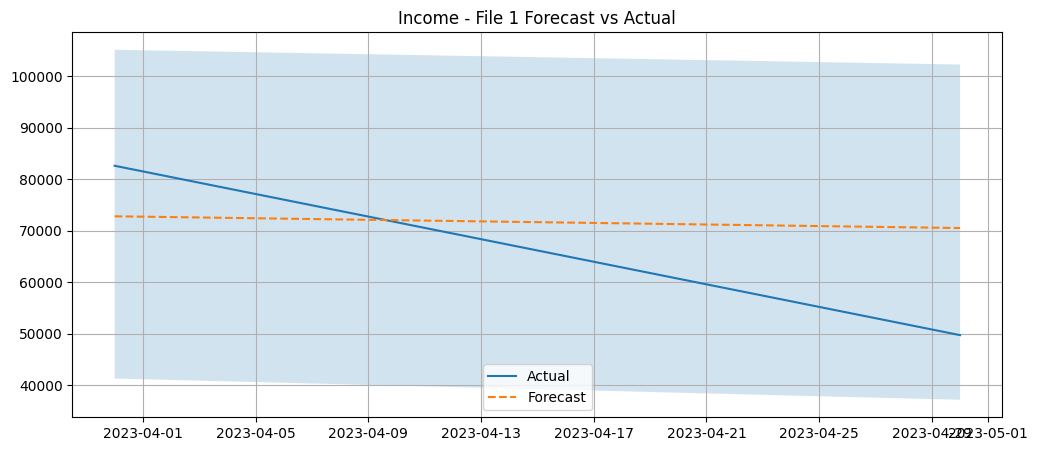

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/al12v0bb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/07xrlwp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38215', 'data', 'file=/tmp/tmprdqotoif/al12v0bb.json', 'init=/tmp/tmprdqotoif/07xrlwp9.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelqkqrc4r4/prophet_model-20250703134815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:15 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 14292.89
MAE: 10742.43
MAPE: 18.58%


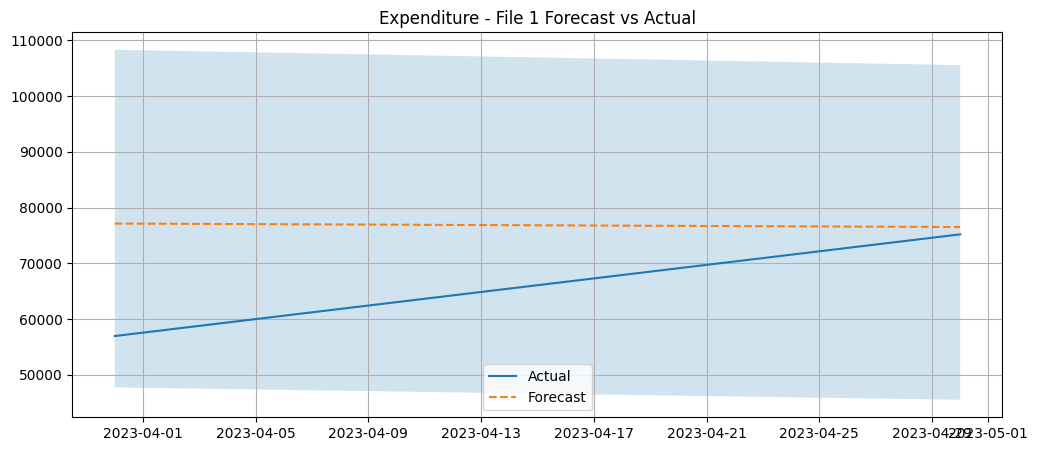

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/bk7q10gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/o2kkwpl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60441', 'data', 'file=/tmp/tmprdqotoif/bk7q10gu.json', 'init=/tmp/tmprdqotoif/o2kkwpl4.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelnxv9nzim/prophet_model-20250703134815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:16 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 25282.12
MAE: 24721.45
MAPE: 96.67%


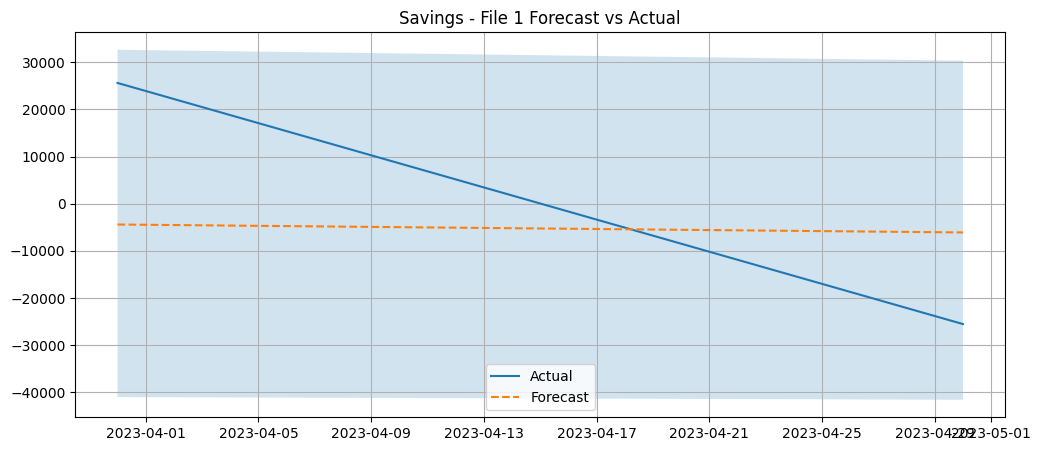

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/nolnssof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/fv5vx0io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83410', 'data', 'file=/tmp/tmprdqotoif/nolnssof.json', 'init=/tmp/tmprdqotoif/fv5vx0io.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelnfgx32rc/prophet_model-20250703134816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:16 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 36418.07
MAE: 31992.67
MAPE: 7.37%


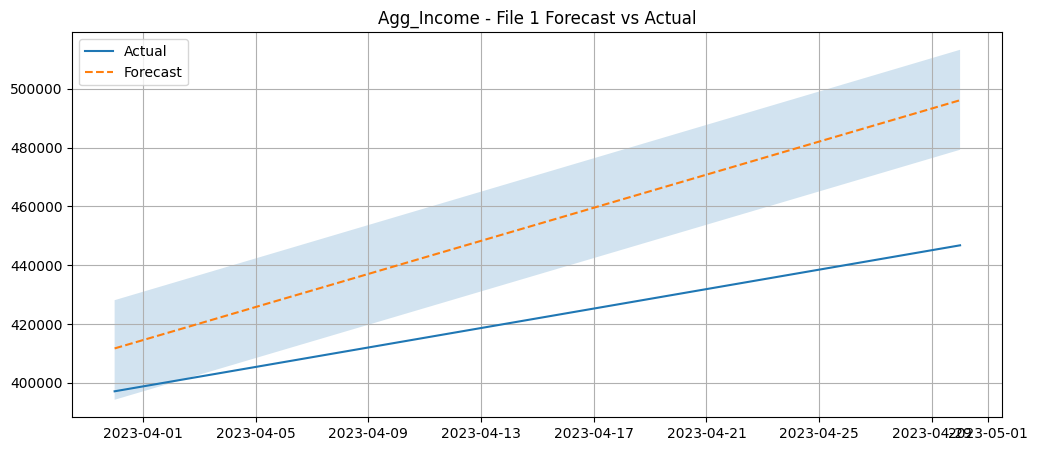

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/i9jcss0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/m88o7kc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22347', 'data', 'file=/tmp/tmprdqotoif/i9jcss0k.json', 'init=/tmp/tmprdqotoif/m88o7kc2.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modeloc5u_g42/prophet_model-20250703134817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:17 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 45234.12
MAE: 44956.28
MAPE: 10.95%


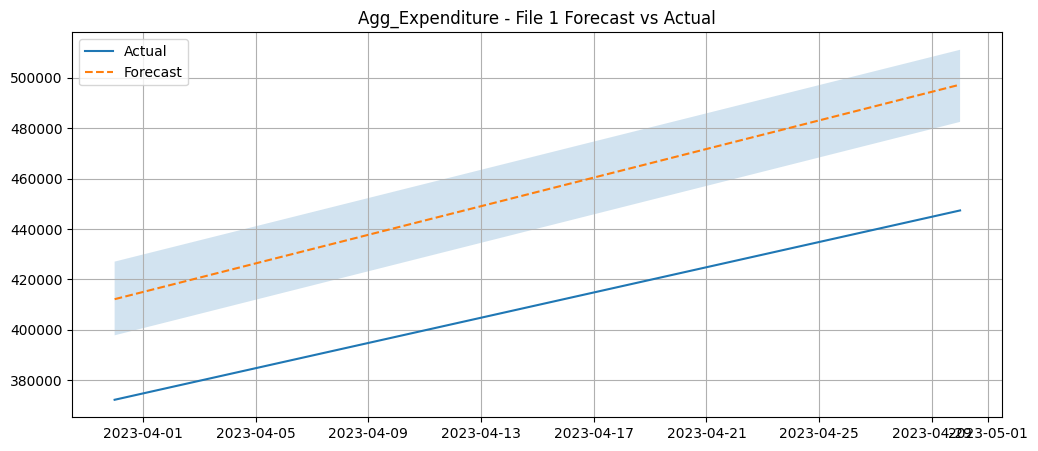

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


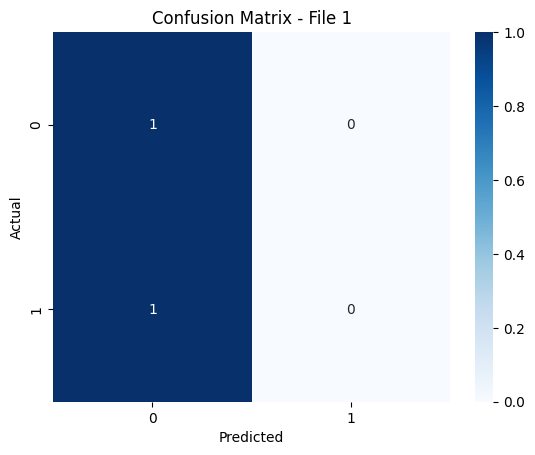



📄 Processing File 2/30: Federal Bank - S1.csv


/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/bflmw5q4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ljnzjqif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30937', 'data', 'file=/tmp/tmprdqotoif/bflmw5q4.json', 'init=/tmp/tmprdqotoif/ljnzjqif.json'

Income Forecast Evaluation:
RMSE: 2372385.82
MAE: 2354029.60
MAPE: 7466.81%


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


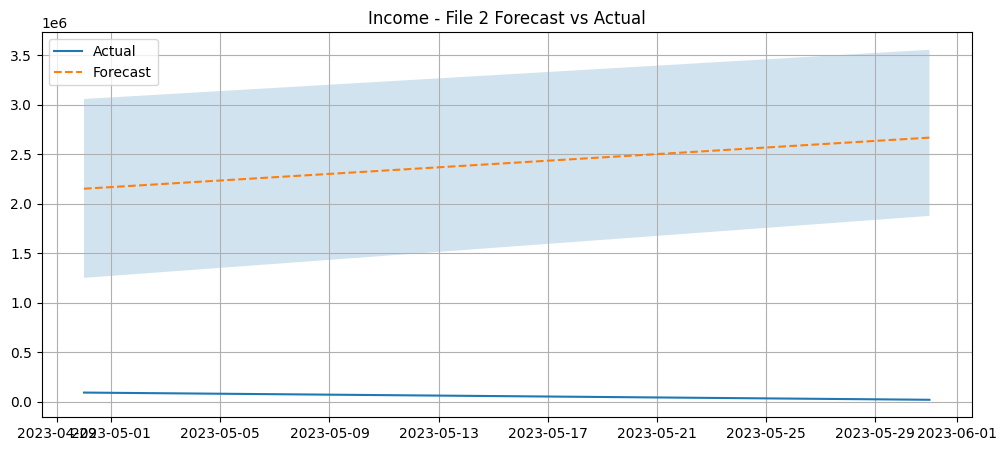

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/lasulk5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/m66azlti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9755', 'data', 'file=/tmp/tmprdqotoif/lasulk5x.json', 'init=/tmp/tmprdqotoif/m66azlti.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelt5iv3add/prophet_model-20250703134818.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:18 - cmdstanpy - INFO - Chain [1] start processing
INF

Expenditure Forecast Evaluation:
RMSE: 2322959.48
MAE: 2304462.57
MAPE: 4301.59%


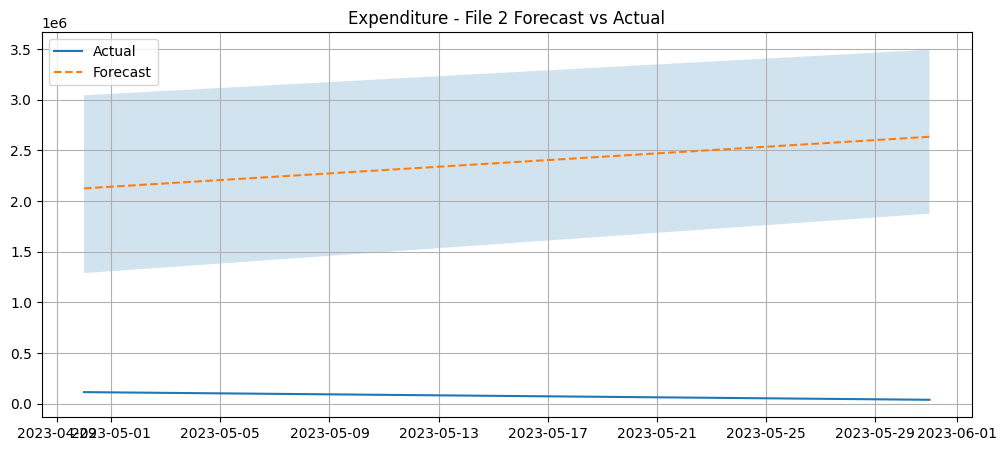

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/a5klnygh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/bm990oav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74725', 'data', 'file=/tmp/tmprdqotoif/a5klnygh.json', 'init=/tmp/tmprdqotoif/bm990oav.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelwo01ruzf/prophet_model-20250703134819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:19 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 49492.93
MAE: 49453.41
MAPE: 268.12%


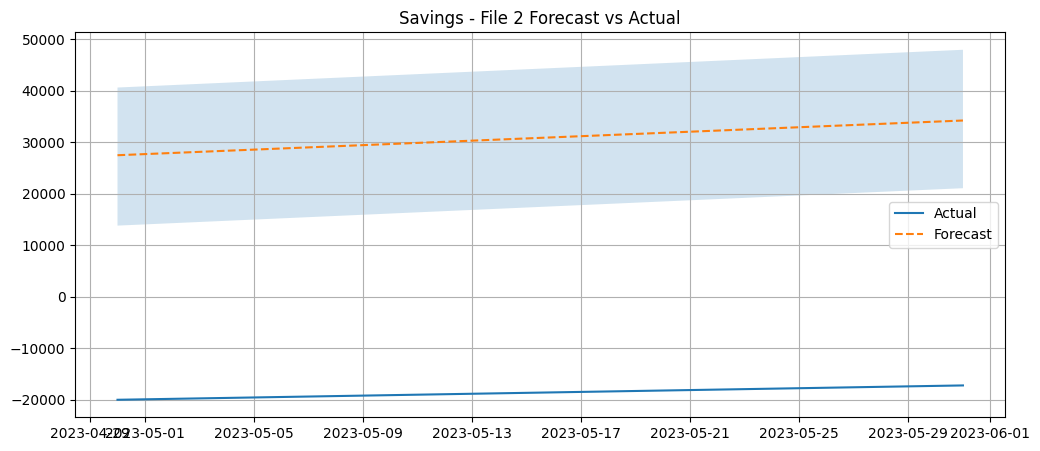

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/xswfpjhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/jl41zzg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73236', 'data', 'file=/tmp/tmprdqotoif/xswfpjhp.json', 'init=/tmp/tmprdqotoif/jl41zzg3.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model0sjfo0j0/prophet_model-20250703134819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:19 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 344149.27
MAE: 328745.60
MAPE: 9.80%


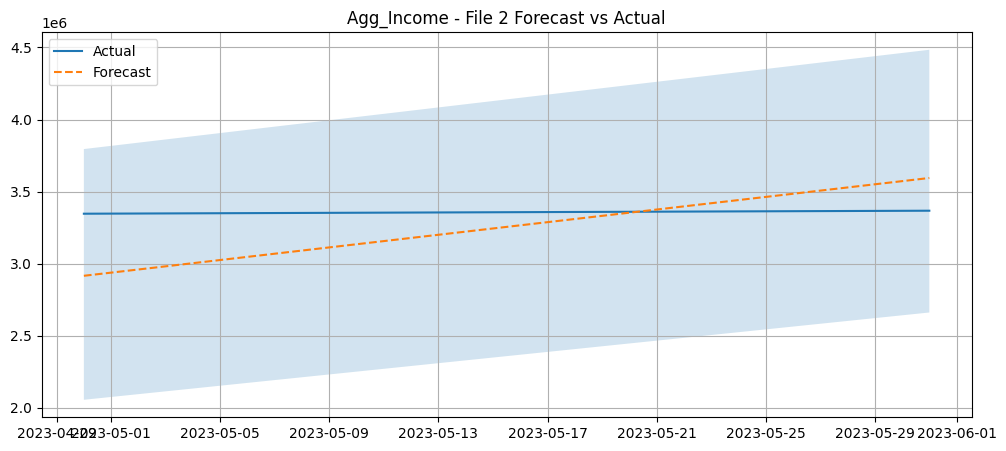

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/glw657ei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/3qbo7yww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=523', 'data', 'file=/tmp/tmprdqotoif/glw657ei.json', 'init=/tmp/tmprdqotoif/3qbo7yww.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelu7o47xqa/prophet_model-20250703134819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:19 - cmdstanpy - INFO - Chain [1] start processing
INFO

Agg_Expenditure Forecast Evaluation:
RMSE: 341931.08
MAE: 315870.80
MAPE: 9.46%


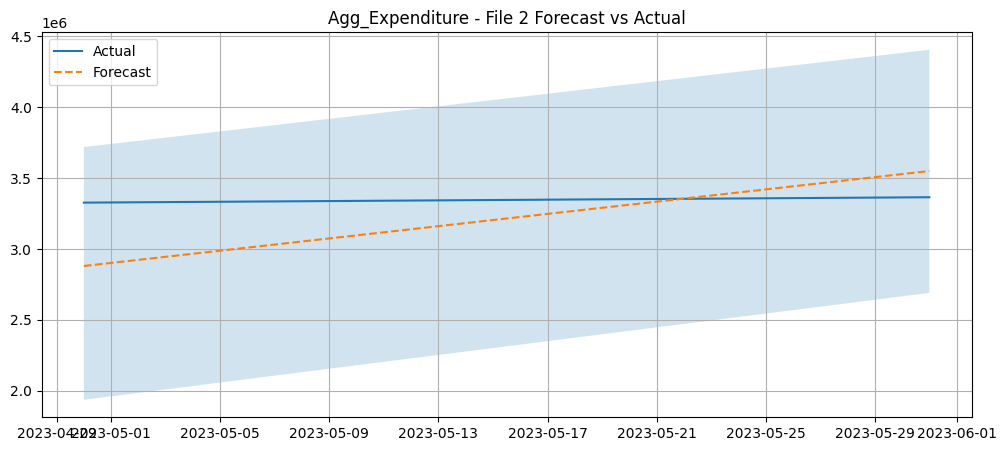

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

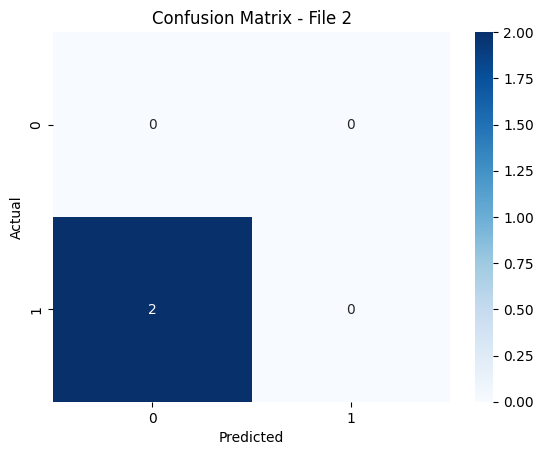

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmds



📄 Processing File 3/30: Bank of Baroda - S3.csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 4/30: Bank of India - S1.csv
❌ Skipped (too few rows).


📄 Processing File 5/30: Canara Bank - S2.csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 6/30: ICICI Bank - S1 .csv


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 37.04
MAE: 37.03
MAPE: inf%


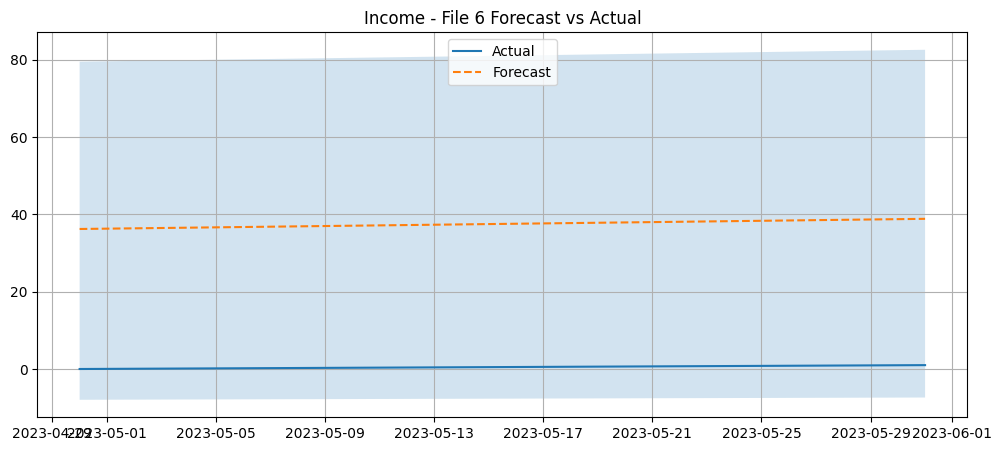

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/wy8jnrkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ess1tx17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93633', 'data', 'file=/tmp/tmprdqotoif/wy8jnrkj.json', 'init=/tmp/tmprdqotoif/ess1tx17.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelwwkmqa7b/prophet_model-20250703134821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:21 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 4743.49
MAE: 4740.56
MAPE: 87.28%


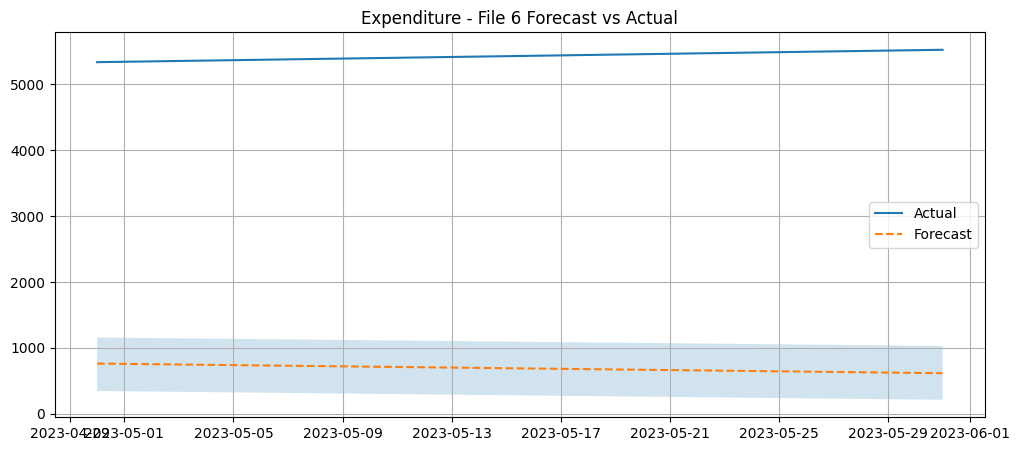

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/w3s06w0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/mw93r8z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60626', 'data', 'file=/tmp/tmprdqotoif/w3s06w0_.json', 'init=/tmp/tmprdqotoif/mw93r8z2.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modeljscye1a8/prophet_model-20250703134821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:21 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 4779.50
MAE: 4776.56
MAPE: 87.95%


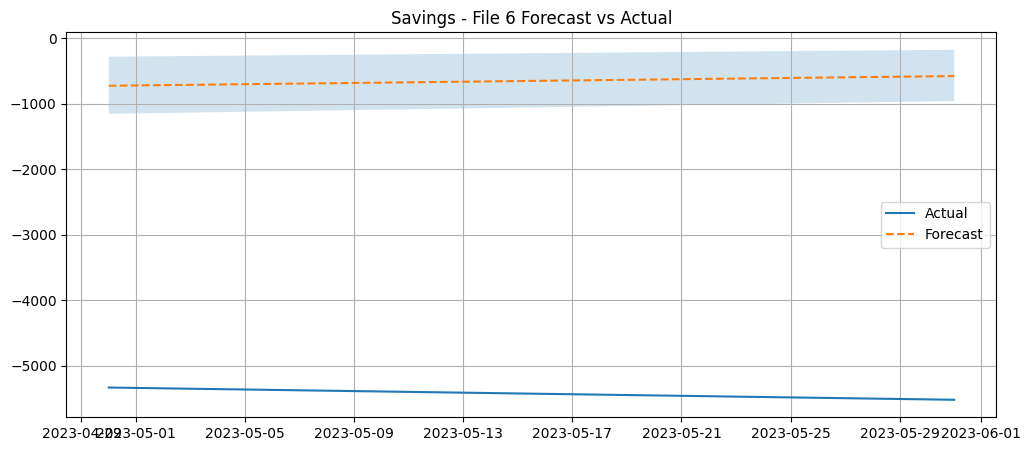

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/prlyqwdi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/hwoecr2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23852', 'data', 'file=/tmp/tmprdqotoif/prlyqwdi.json', 'init=/tmp/tmprdqotoif/hwoecr2x.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modeloncjmf0u/prophet_model-20250703134822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:22 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 40.23
MAE: 37.65
MAPE: 26.20%


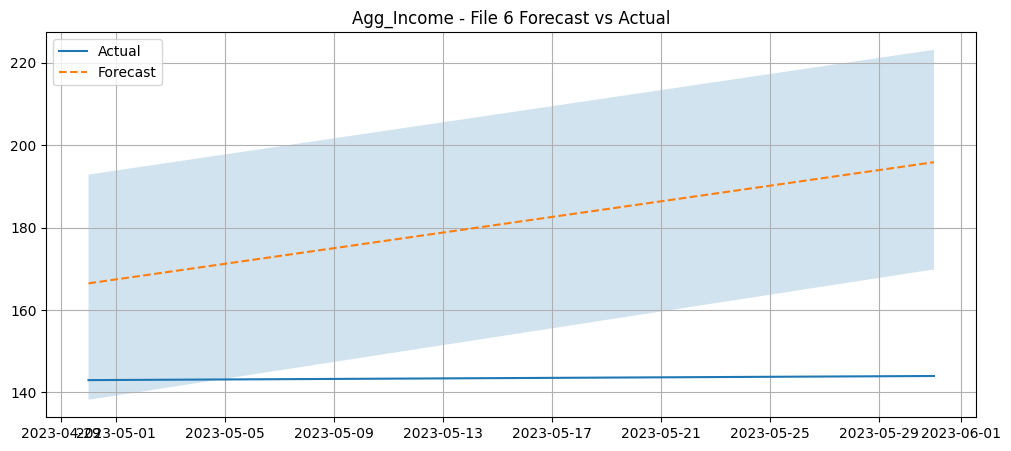

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/wdmgdagu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/rjj76hb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47237', 'data', 'file=/tmp/tmprdqotoif/wdmgdagu.json', 'init=/tmp/tmprdqotoif/rjj76hb1.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modeloiiyi9w6/prophet_model-20250703134822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:22 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 6616.30
MAE: 6261.85
MAPE: 43.30%


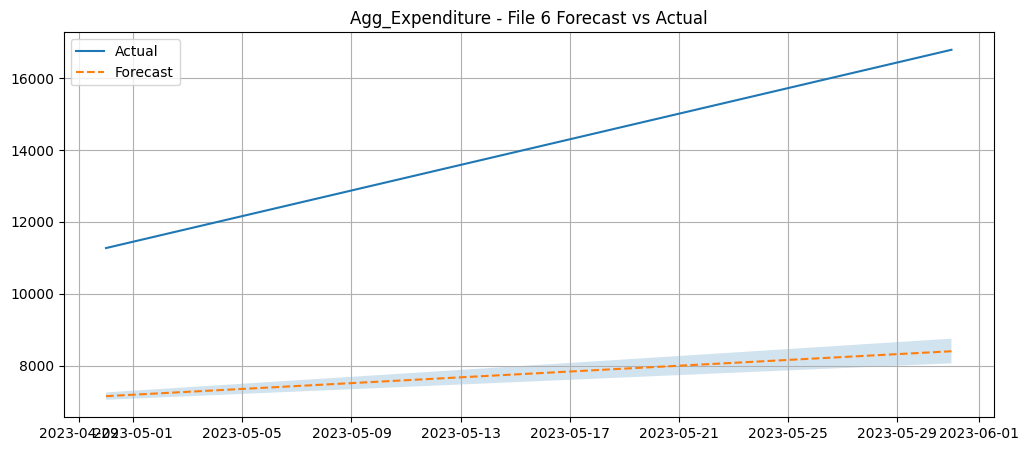

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-5-3484043052.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

❗ Not enough variation in risk labels or data for classification.


📄 Processing File 7/30: HDFC Bank - S3.csv
❌ Skipped (too few rows).


📄 Processing File 8/30: Paytm - S2 .csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 9/30: Paytm - S1 .csv
❌ Skipped (too few rows).


📄 Processing File 10/30: Axis Bank - S3.csv


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 10102.51
MAE: 9467.58
MAPE: 208.49%


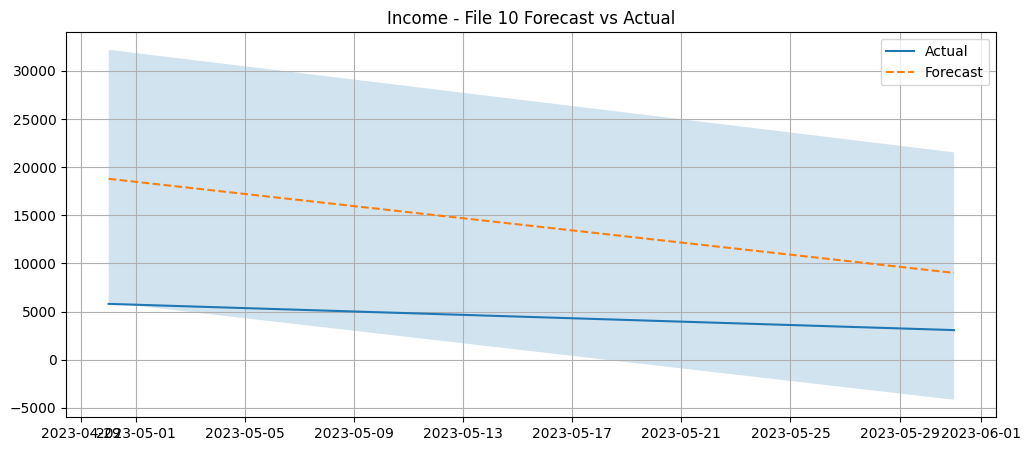

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/qbnmcp58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/j4gazvgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86344', 'data', 'file=/tmp/tmprdqotoif/qbnmcp58.json', 'init=/tmp/tmprdqotoif/j4gazvgf.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelf0b8znug/prophet_model-20250703134823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:23 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 12545.56
MAE: 12372.69
MAPE: 430.21%


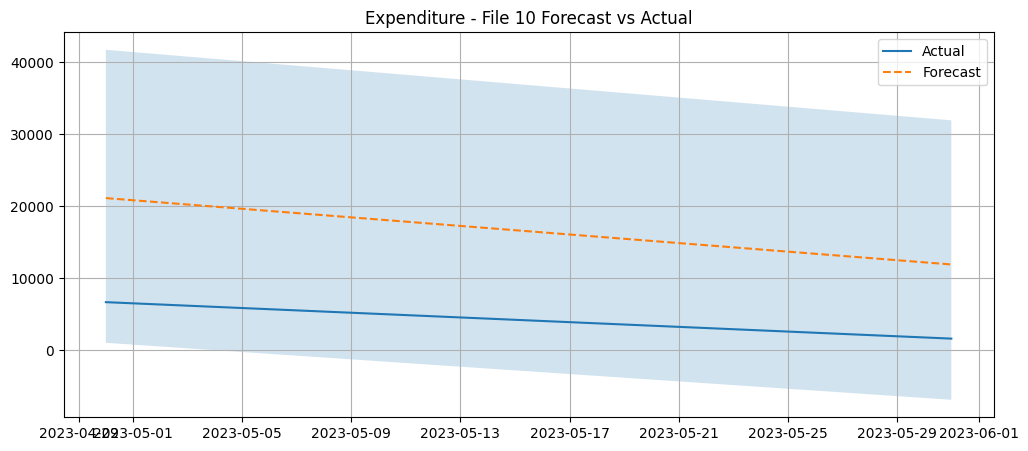

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/n23hn_e_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/up6mbo_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5264', 'data', 'file=/tmp/tmprdqotoif/n23hn_e_.json', 'init=/tmp/tmprdqotoif/up6mbo_a.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelhcvrx7la/prophet_model-20250703134824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:24 - cmdstanpy - INFO - Chain [1] start processing
INF

Savings Forecast Evaluation:
RMSE: 3175.98
MAE: 2837.53
MAPE: 226.13%


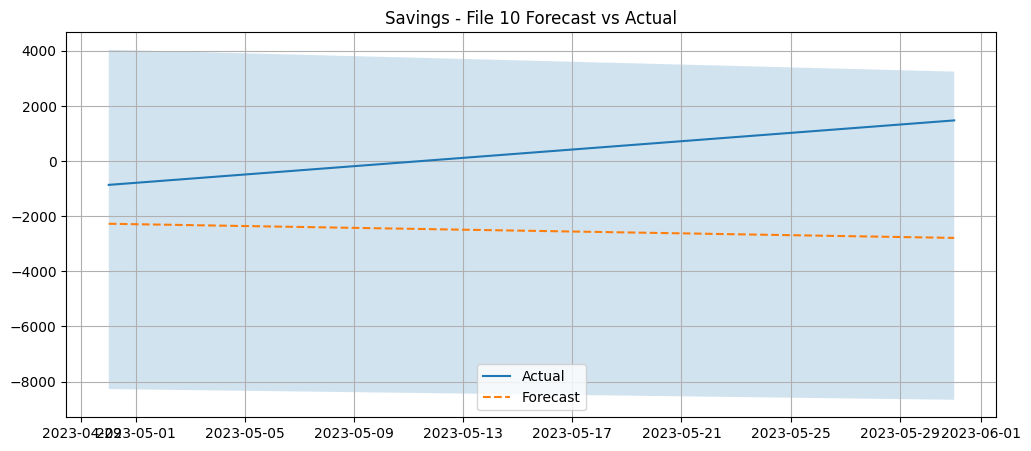

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ldi1kqxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/rn6v50m_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98061', 'data', 'file=/tmp/tmprdqotoif/ldi1kqxx.json', 'init=/tmp/tmprdqotoif/rn6v50m_.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model41j0qb9s/prophet_model-20250703134824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:24 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 49297.34
MAE: 46443.12
MAPE: 26.14%


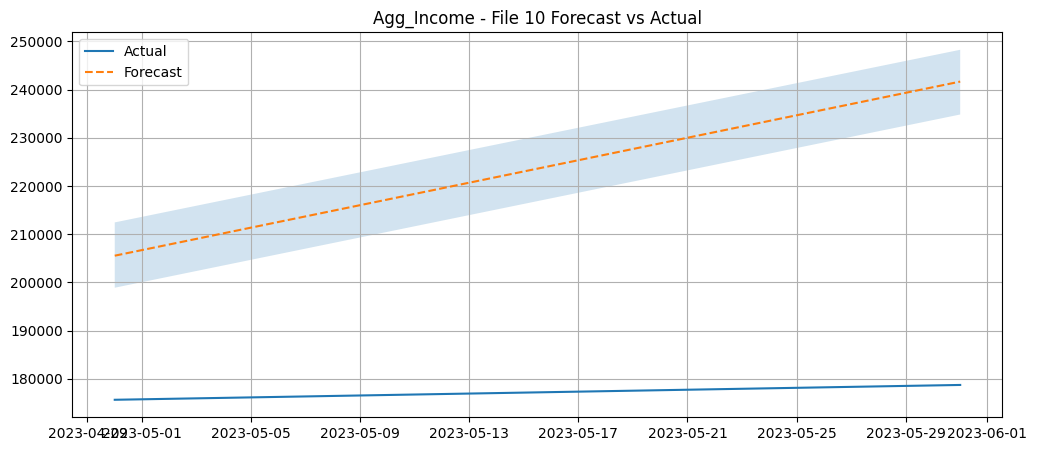

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/0a0olvzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/qq6v1xeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12515', 'data', 'file=/tmp/tmprdqotoif/0a0olvzi.json', 'init=/tmp/tmprdqotoif/qq6v1xeg.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modeldc1su74_/prophet_model-20250703134825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:25 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 46584.48
MAE: 43314.29
MAPE: 23.84%


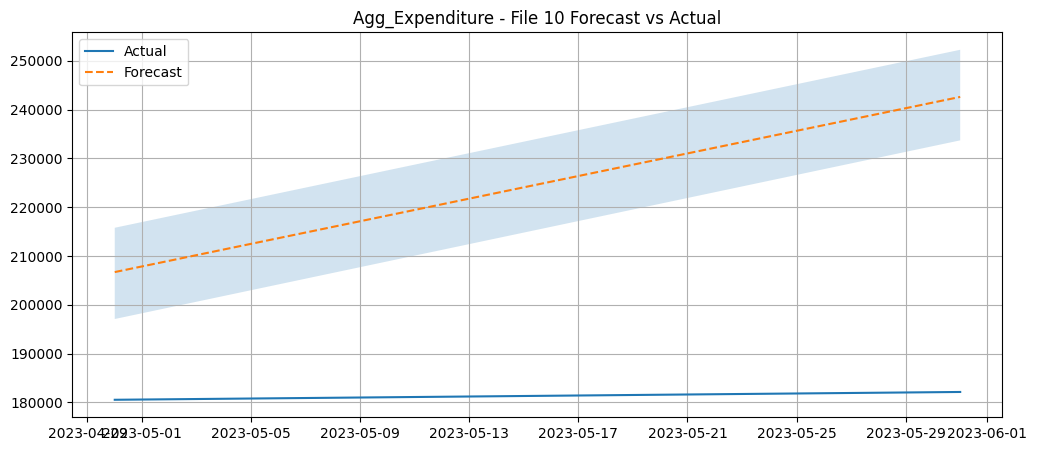

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



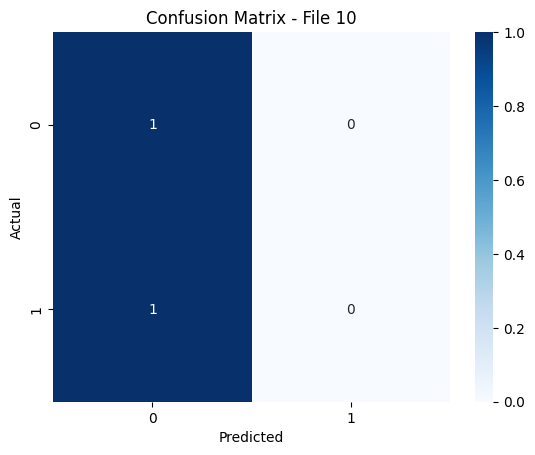

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/3ml5w9o8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/2z9zbkb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52208', 'data', 'file=/tmp/tmprdqotoif/3ml5w9o8.json', 'init=/tmp/tmprdqotoif/2z9zbkb_.json'



📄 Processing File 11/30: Axis Bank - S1.csv
Income Forecast Evaluation:
RMSE: 361248.89
MAE: 338634.87
MAPE: inf%


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


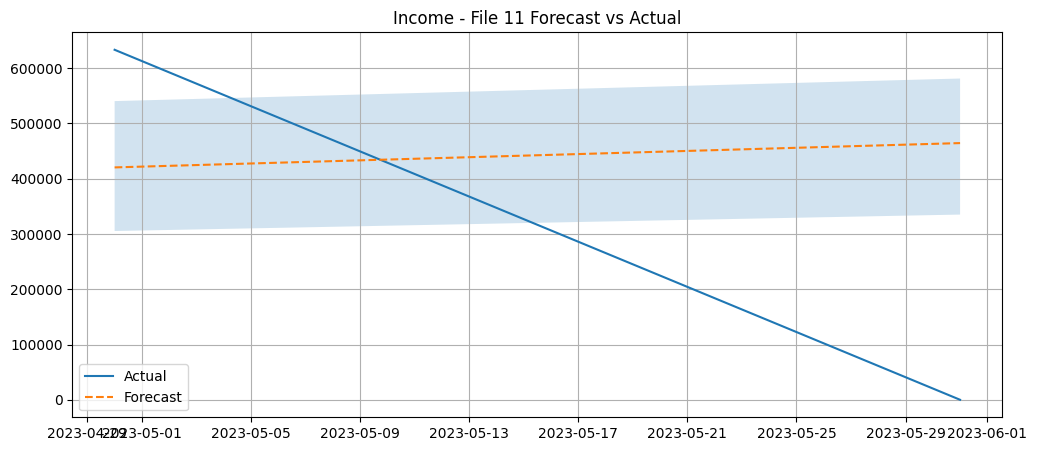

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/415gp13a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/33jk0bm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12171', 'data', 'file=/tmp/tmprdqotoif/415gp13a.json', 'init=/tmp/tmprdqotoif/33jk0bm8.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelx2ufzeup/prophet_model-20250703134827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:27 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 362292.59
MAE: 342916.16
MAPE: 3849.23%


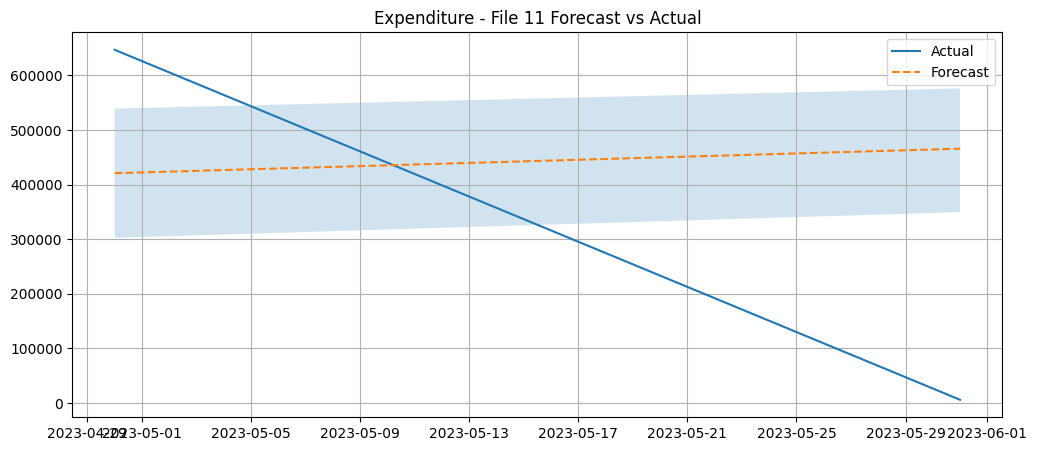

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/v30q3uvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/9k3ate6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92556', 'data', 'file=/tmp/tmprdqotoif/v30q3uvo.json', 'init=/tmp/tmprdqotoif/9k3ate6q.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelutht5yt4/prophet_model-20250703134827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:27 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 9872.16
MAE: 8905.83
MAPE: 86.81%


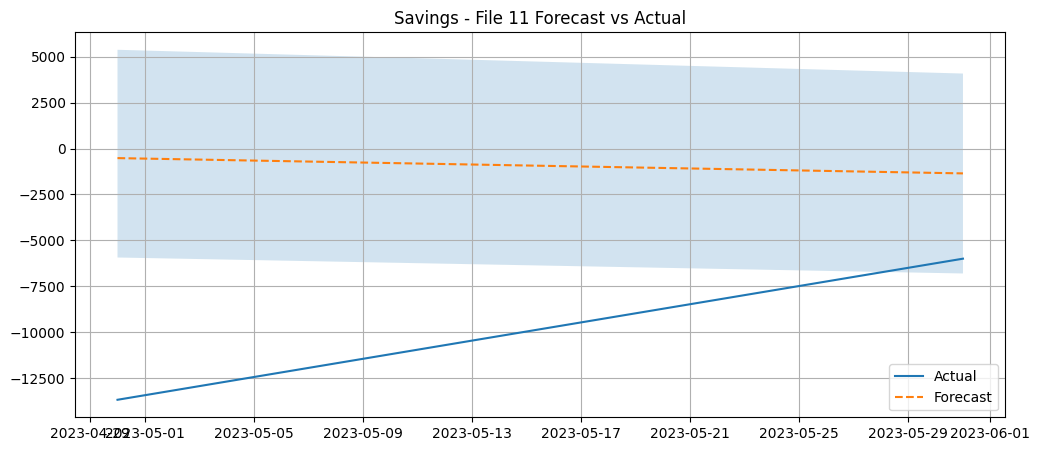

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/vczcldas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/cubb528m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55116', 'data', 'file=/tmp/tmprdqotoif/vczcldas.json', 'init=/tmp/tmprdqotoif/cubb528m.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelp3dmd73z/prophet_model-20250703134828.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:28 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 324081.57
MAE: 287644.96
MAPE: 13.73%


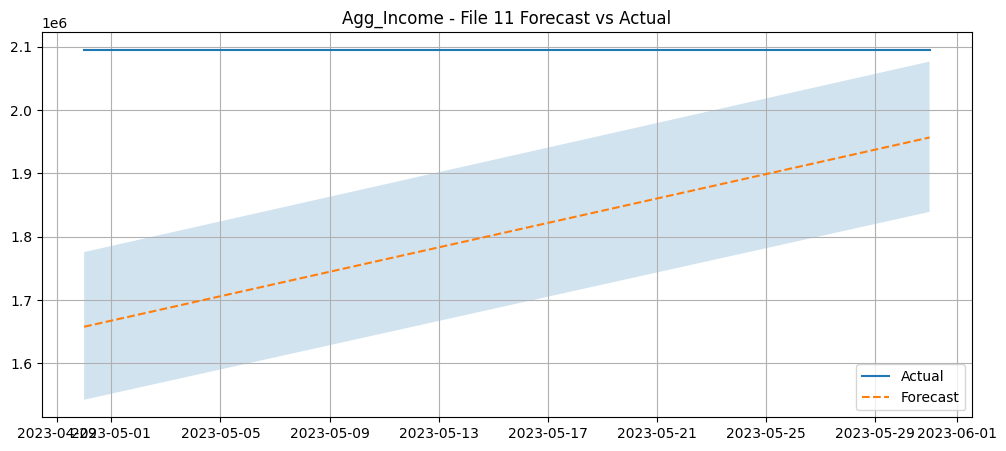

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/fq31uatz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/6_r0tf9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85901', 'data', 'file=/tmp/tmprdqotoif/fq31uatz.json', 'init=/tmp/tmprdqotoif/6_r0tf9a.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelxkzp0vo3/prophet_model-20250703134828.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:28 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 335544.64
MAE: 301886.94
MAPE: 14.37%


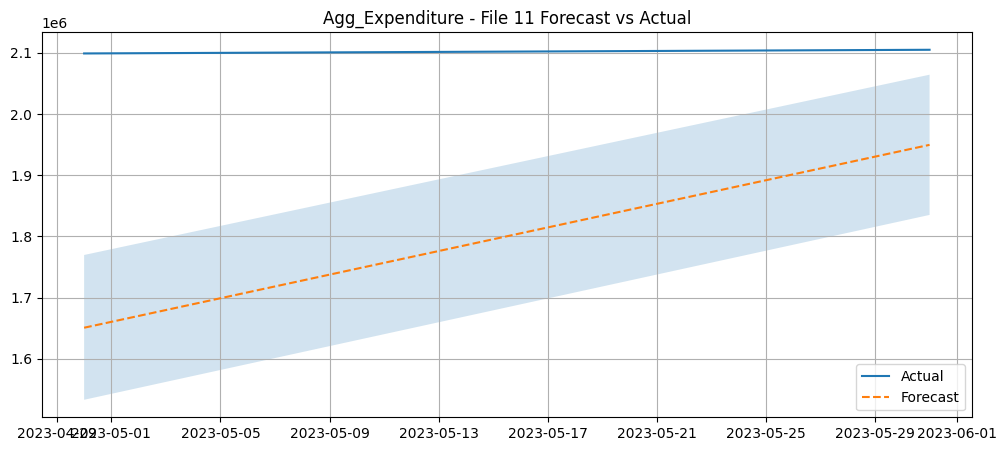

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

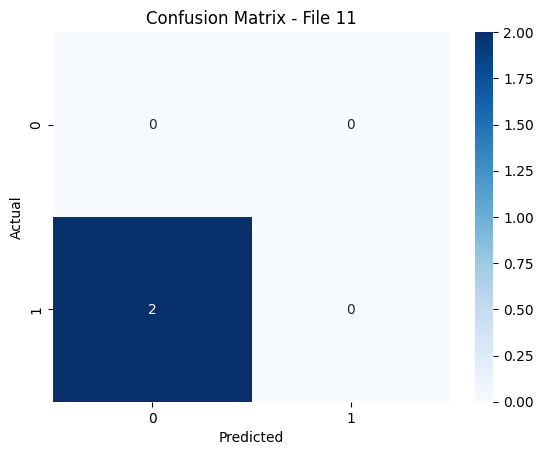

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/rwlfawf1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/cwnvfr8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=261', 'data', 'file=/tmp/tmprdqotoif/rwlfawf1.json', 'init=/tmp/tmprdqotoif/cwnvfr8s.json', 



📄 Processing File 12/30: Bank of Baroda - S1 .csv


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 9590.54
MAE: 6953.65
MAPE: 66.48%


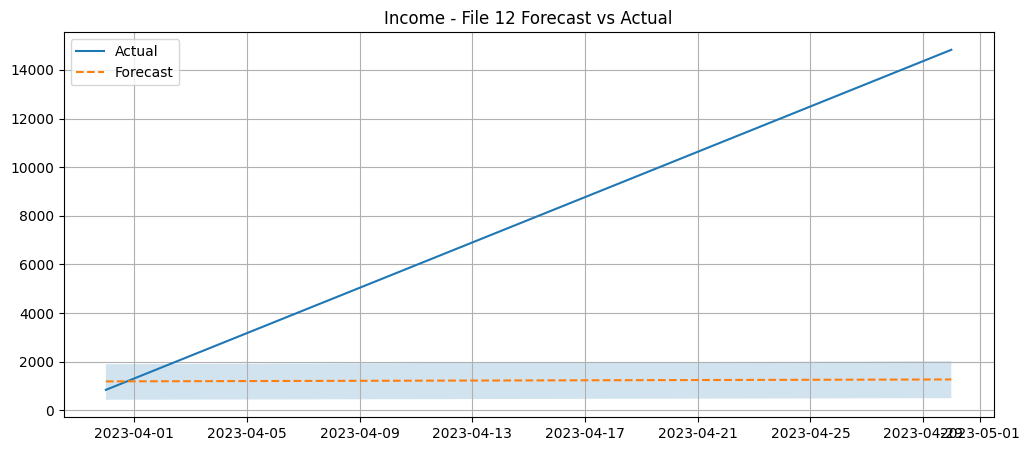

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/8gl74no6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/gqr5vcmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60771', 'data', 'file=/tmp/tmprdqotoif/8gl74no6.json', 'init=/tmp/tmprdqotoif/gqr5vcmx.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelmsxzoe9z/prophet_model-20250703134831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:31 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 9796.19
MAE: 7215.08
MAPE: 78.88%


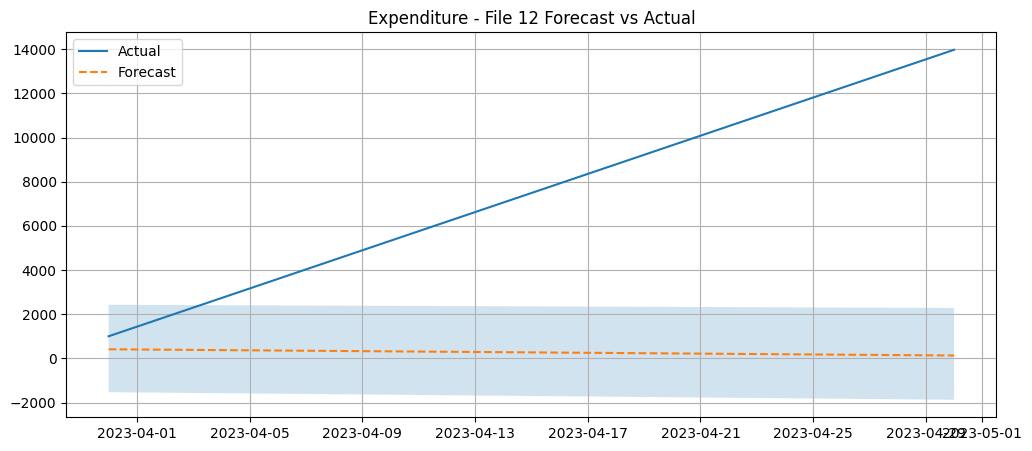

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/jocdzjwr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/kajoxjkr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55143', 'data', 'file=/tmp/tmprdqotoif/jocdzjwr.json', 'init=/tmp/tmprdqotoif/kajoxjkr.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model2coy5bum/prophet_model-20250703134831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:31 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 698.40
MAE: 616.93
MAPE: 306.72%


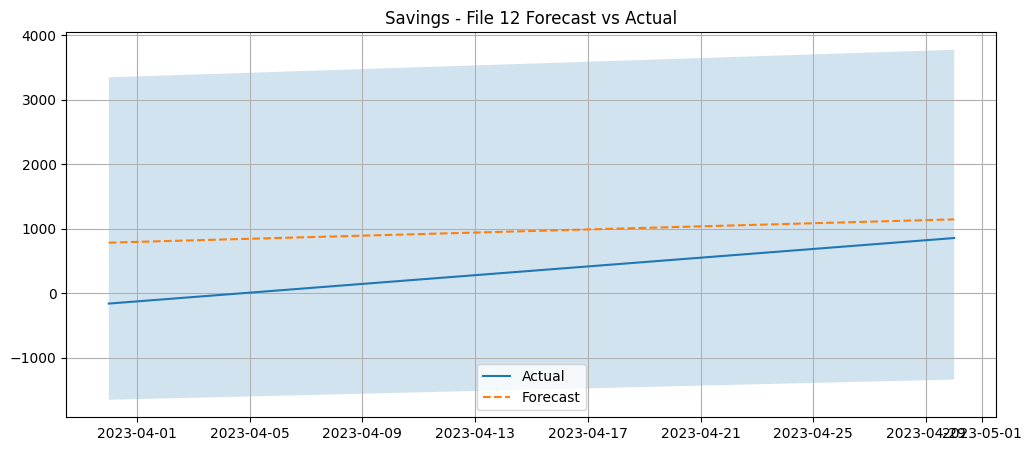

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/oyaeneoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/kr_s_shv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16207', 'data', 'file=/tmp/tmprdqotoif/oyaeneoq.json', 'init=/tmp/tmprdqotoif/kr_s_shv.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model35froww9/prophet_model-20250703134832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:32 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 10215.22
MAE: 7356.71
MAPE: 37.50%


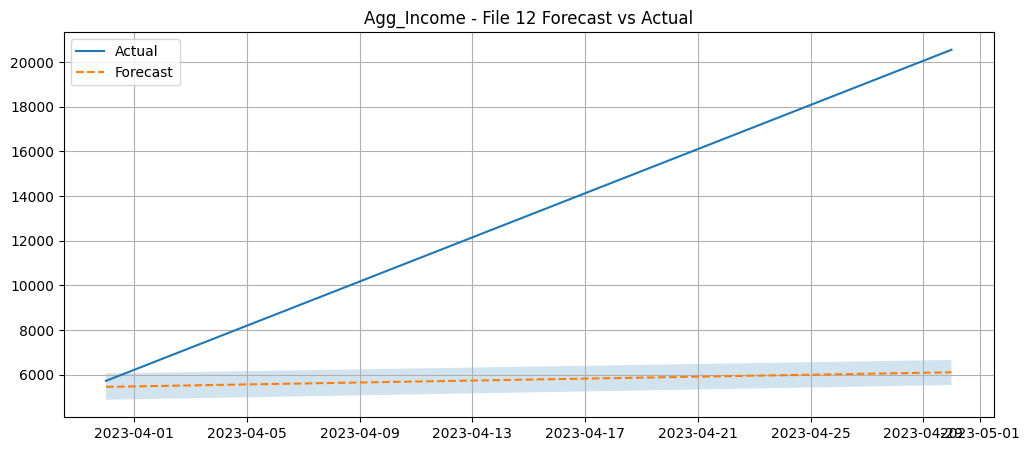

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/foifpr9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/x3cqvc2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19898', 'data', 'file=/tmp/tmprdqotoif/foifpr9o.json', 'init=/tmp/tmprdqotoif/x3cqvc2_.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelbf_qco6_/prophet_model-20250703134832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:32 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 9439.29
MAE: 6771.57
MAPE: 26.56%


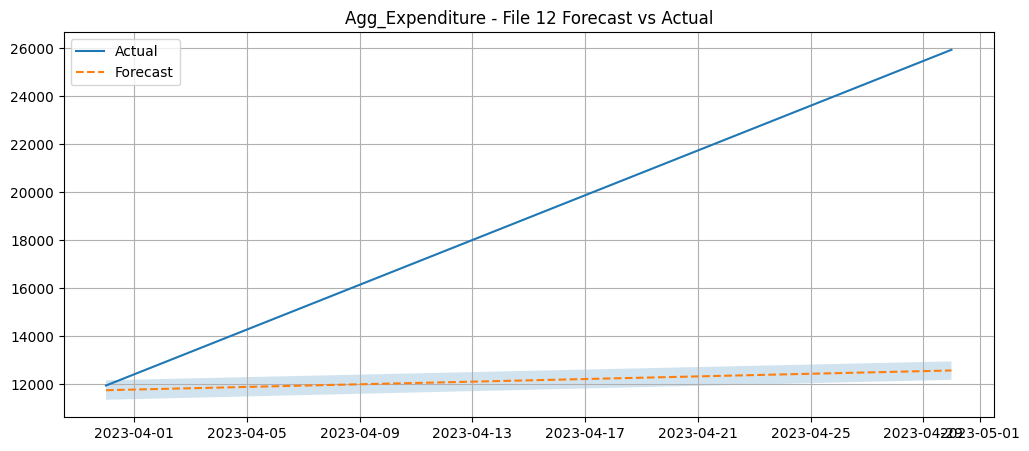

Classification Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


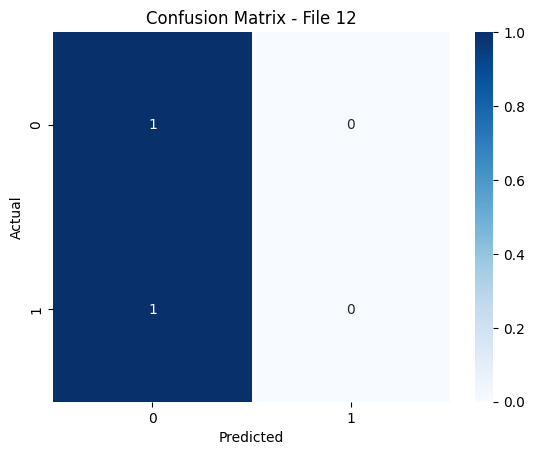

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/epai48qe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/aomqpm2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42444', 'data', 'file=/tmp/tmprdqotoif/epai48qe.json', 'init=/tmp/tmprdqotoif/aomqpm2u.json'



📄 Processing File 13/30: HDFC Bank - S2.csv
❌ Skipped (too few rows).


📄 Processing File 14/30: HDFC Bank - S1.csv
❌ Skipped (too few rows).


📄 Processing File 15/30: KMB - S2.csv


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 9121.42
MAE: 8757.61
MAPE: 67.26%


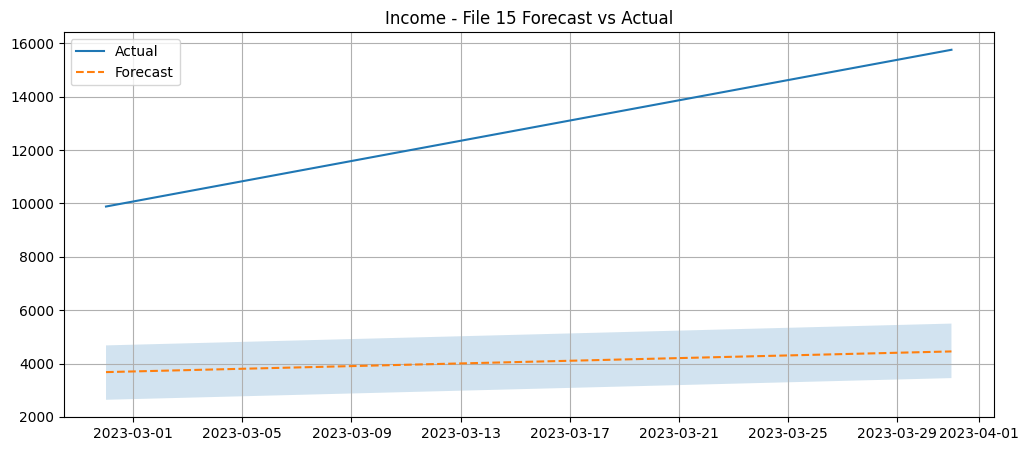

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/vl6liad8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/c661prmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35577', 'data', 'file=/tmp/tmprdqotoif/vl6liad8.json', 'init=/tmp/tmprdqotoif/c661prmm.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelnygx7s7a/prophet_model-20250703134833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:33 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 12771.67
MAE: 12588.11
MAPE: 101.48%


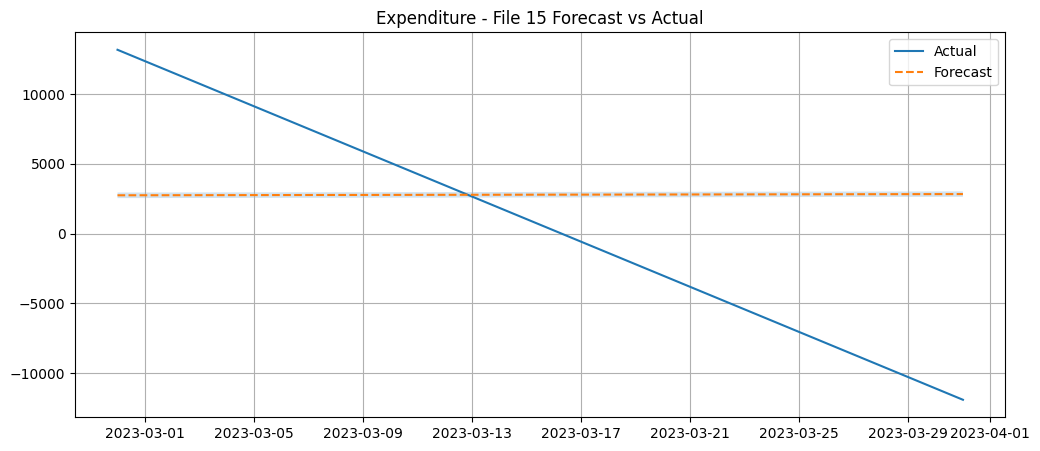

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/bd0dh4cb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/w46pl3fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35426', 'data', 'file=/tmp/tmprdqotoif/bd0dh4cb.json', 'init=/tmp/tmprdqotoif/w46pl3fk.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelzo44agxc/prophet_model-20250703134834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 18678.03
MAE: 15142.30
MAPE: 111.00%


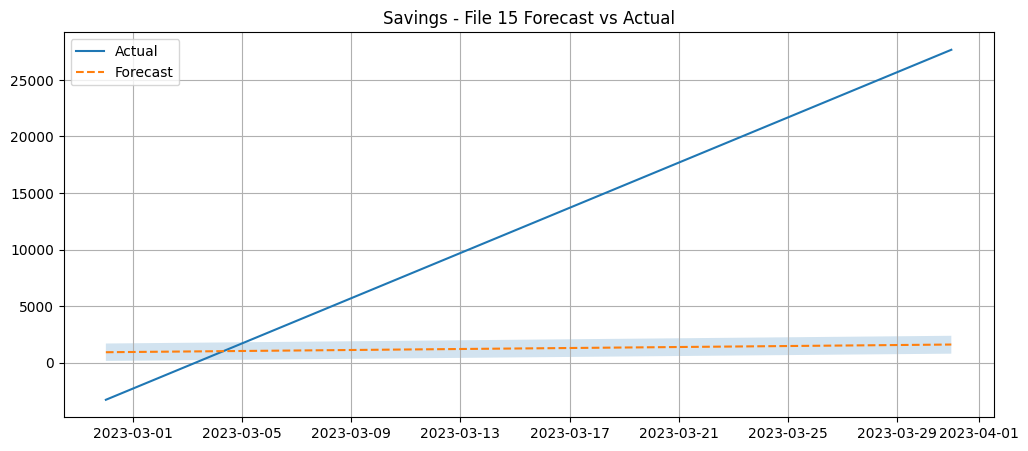

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/vcq1w32f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/p3w6ueot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46560', 'data', 'file=/tmp/tmprdqotoif/vcq1w32f.json', 'init=/tmp/tmprdqotoif/p3w6ueot.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelgdp2aet9/prophet_model-20250703134834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:34 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 17379.79
MAE: 15939.17
MAPE: 60.94%


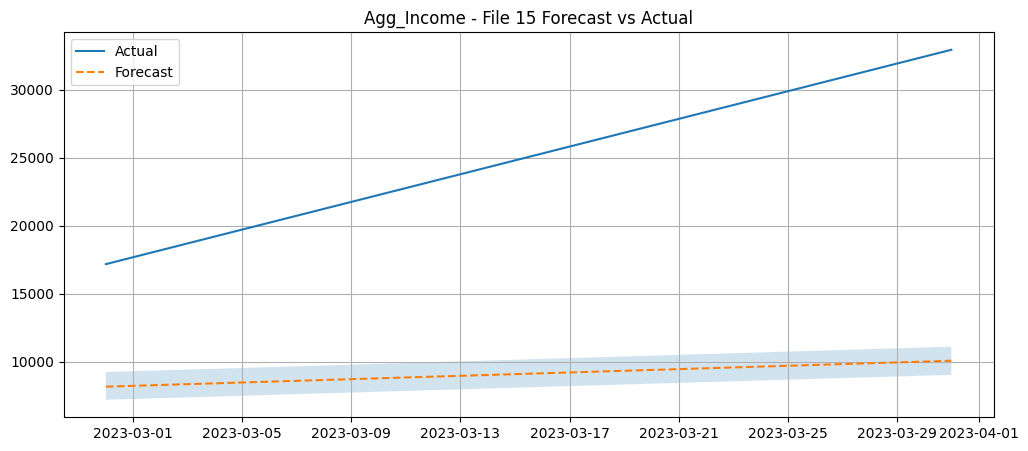

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/empifuqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/to_41sci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94620', 'data', 'file=/tmp/tmprdqotoif/empifuqb.json', 'init=/tmp/tmprdqotoif/to_41sci.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelhdbkg4gc/prophet_model-20250703134835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:35 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 8064.99
MAE: 7331.78
MAPE: 40.29%


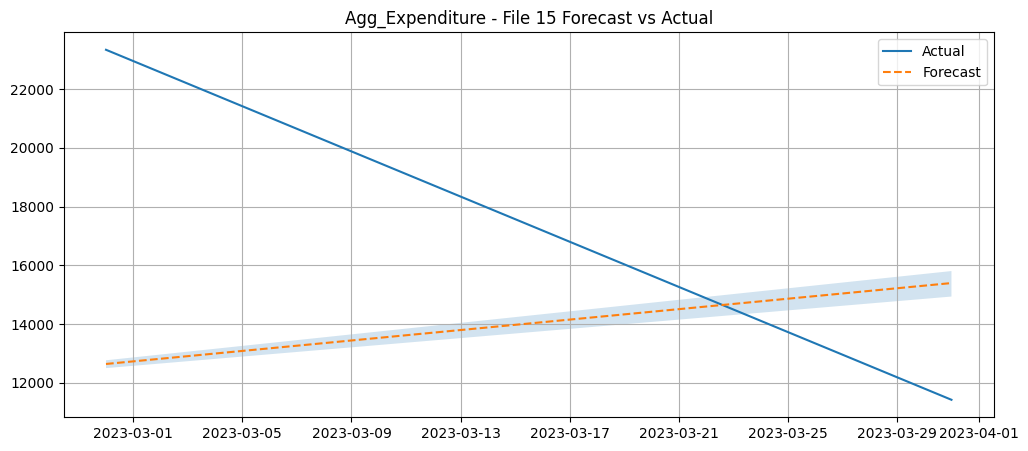

Classification Accuracy: 0.0
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


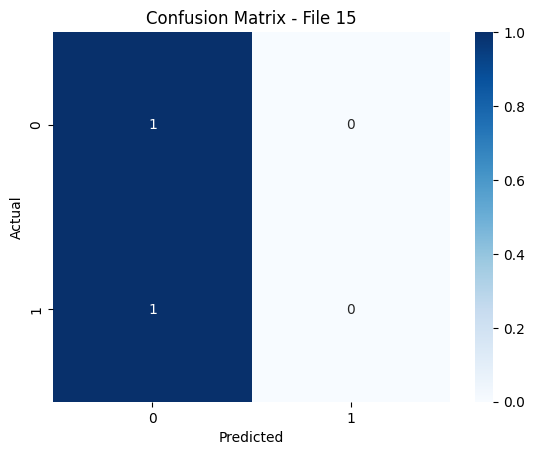



📄 Processing File 16/30: Paytm - S3.csv


/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ms8dv3ly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/rmwbrfaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70099', 'data', 'file=/tmp/tmprdqotoif/ms8dv3ly.json', 'init=/tmp/tmprdqotoif/rmwbrfaz.json'

❌ Skipped (too few rows).


📄 Processing File 17/30: Canara Bank - S3.csv
Income Forecast Evaluation:
RMSE: 2800.64
MAE: 2573.88
MAPE: 146.01%


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


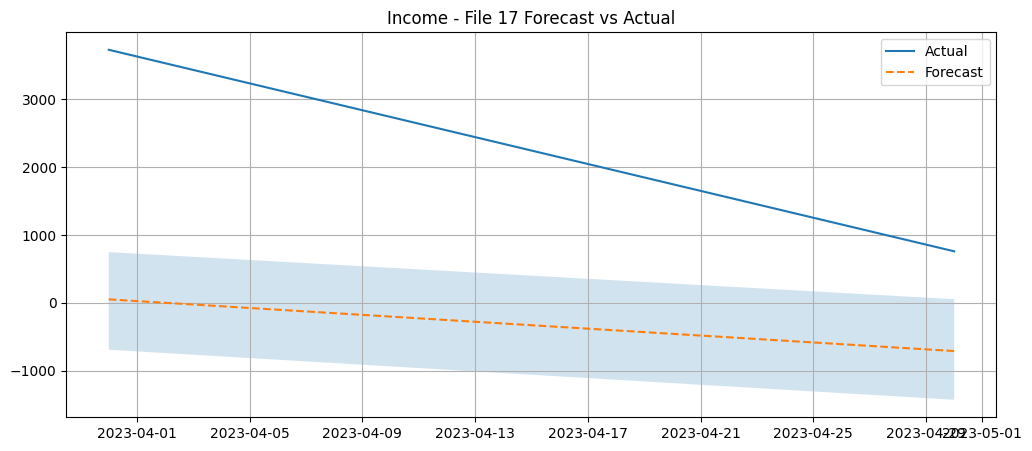

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/wmxkp1az.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/87z90nvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3151', 'data', 'file=/tmp/tmprdqotoif/wmxkp1az.json', 'init=/tmp/tmprdqotoif/87z90nvl.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelhq3ykv94/prophet_model-20250703134838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:38 - cmdstanpy - INFO - Chain [1] start processing
INF

Expenditure Forecast Evaluation:
RMSE: 4762.35
MAE: 4568.75
MAPE: 227.42%


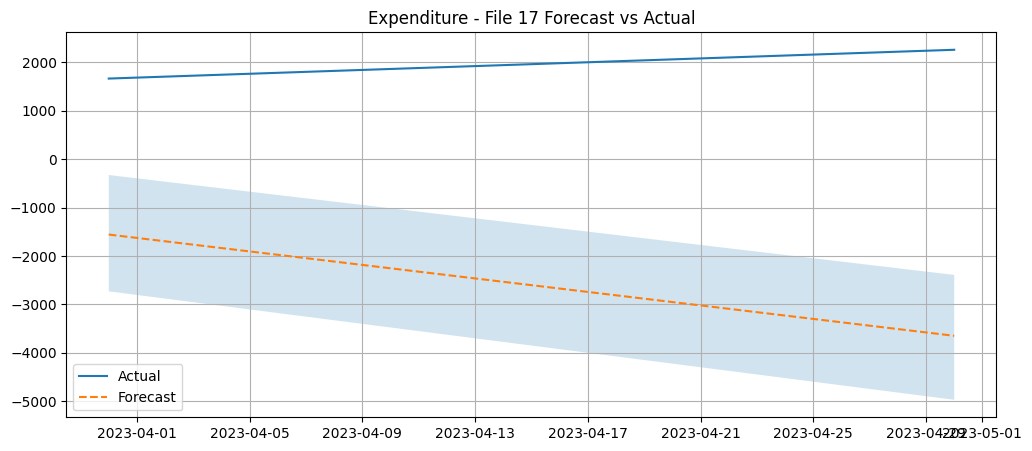

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/n_reqo7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/zduezvwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26783', 'data', 'file=/tmp/tmprdqotoif/n_reqo7i.json', 'init=/tmp/tmprdqotoif/zduezvwc.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model6blx052r/prophet_model-20250703134839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:39 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 3145.89
MAE: 2446.19
MAPE: 158.62%


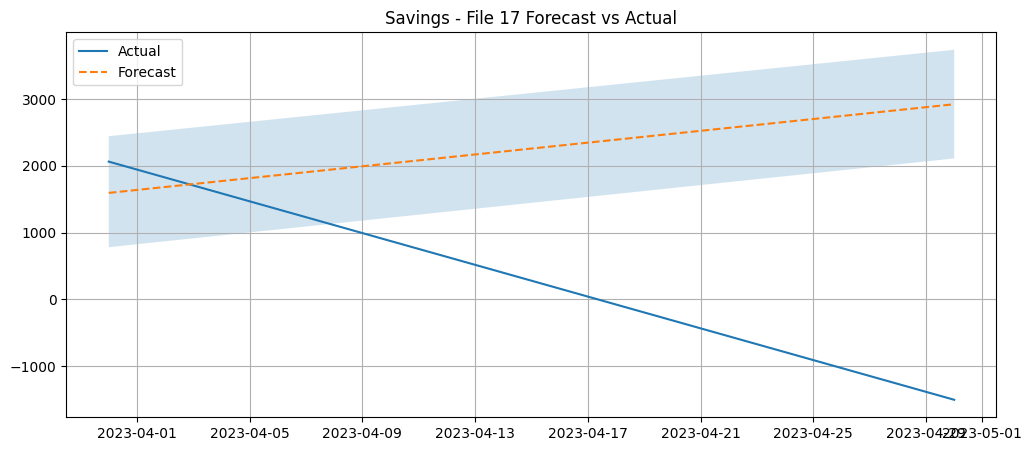

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ys1zwn96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/s7z5yb_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77411', 'data', 'file=/tmp/tmprdqotoif/ys1zwn96.json', 'init=/tmp/tmprdqotoif/s7z5yb_a.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelrbat9a4h/prophet_model-20250703134839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:39 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 1907.00
MAE: 1879.68
MAPE: 15.84%


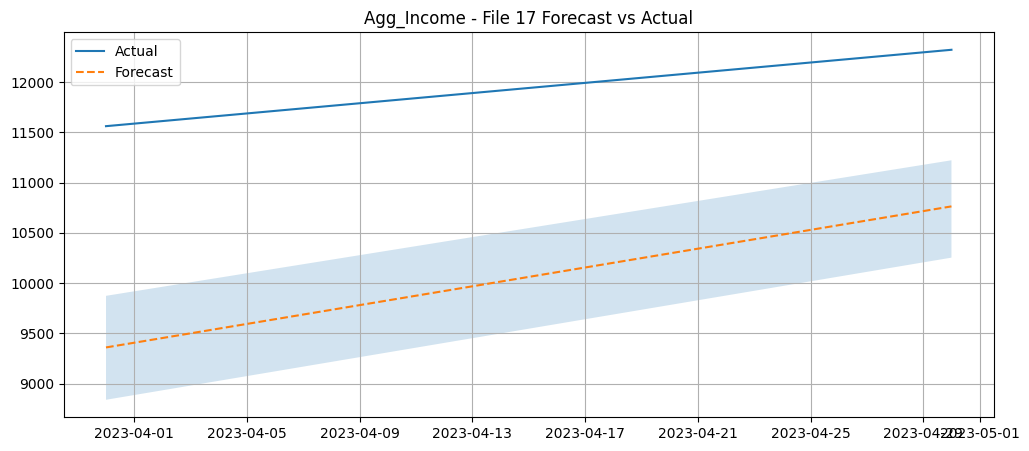

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/akj_w4g6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/h_hqd9fq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76830', 'data', 'file=/tmp/tmprdqotoif/akj_w4g6.json', 'init=/tmp/tmprdqotoif/h_hqd9fq.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelg26rr_wh/prophet_model-20250703134840.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:40 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 2130.53
MAE: 2123.51
MAPE: 12.07%


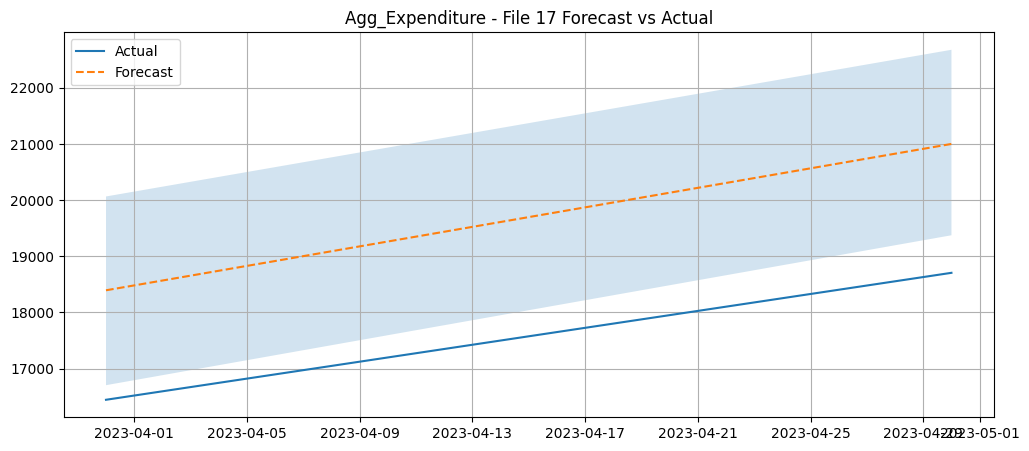

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


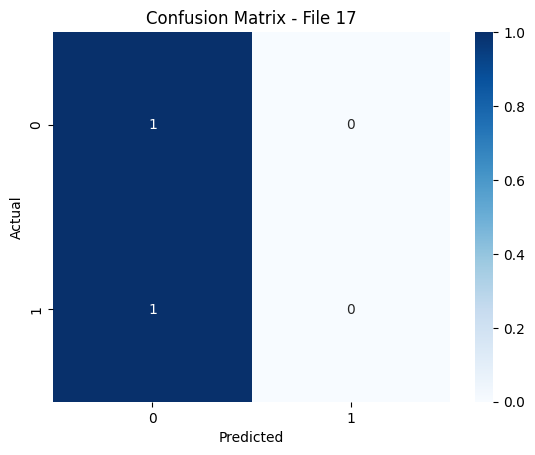

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/n4qzytcl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/lsl5qqjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36951', 'data', 'file=/tmp/tmprdqotoif/n4qzytcl.json', 'init=/tmp/tmprdqotoif/lsl5qqjd.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modeln50ry6pv/prophet_model-20250703134841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:41 - cmdstanpy - INFO - Chain [1] start processing
IN



📄 Processing File 18/30: Canara Bank - S1 .csv


13:48:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 599.08
MAE: 580.46
MAPE: 74.83%


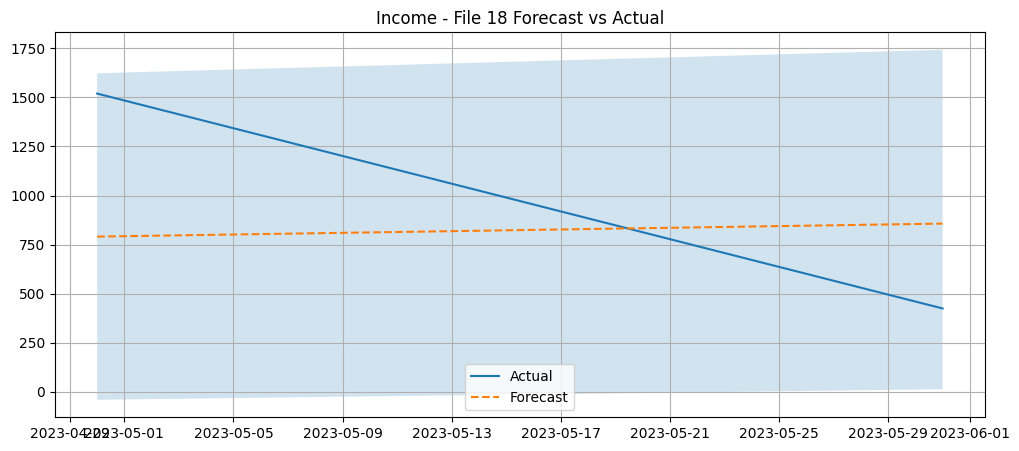

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/wrclpmce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/e5hptiwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50371', 'data', 'file=/tmp/tmprdqotoif/wrclpmce.json', 'init=/tmp/tmprdqotoif/e5hptiwg.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modellk8yh5k4/prophet_model-20250703134841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:41 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 3333.13
MAE: 2606.18
MAPE: 1095.76%


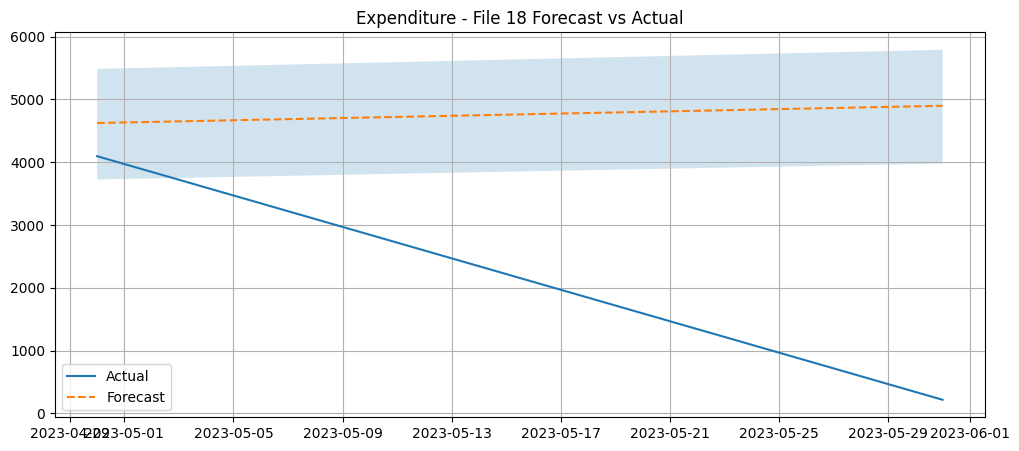

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/3gwy3j5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/vla_yx5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6095', 'data', 'file=/tmp/tmprdqotoif/3gwy3j5d.json', 'init=/tmp/tmprdqotoif/vla_yx5i.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelfy1d9eiq/prophet_model-20250703134842.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:42 - cmdstanpy - INFO - Chain [1] start processing
INF

Savings Forecast Evaluation:
RMSE: 3131.04
MAE: 2750.05
MAPE: 1035.50%


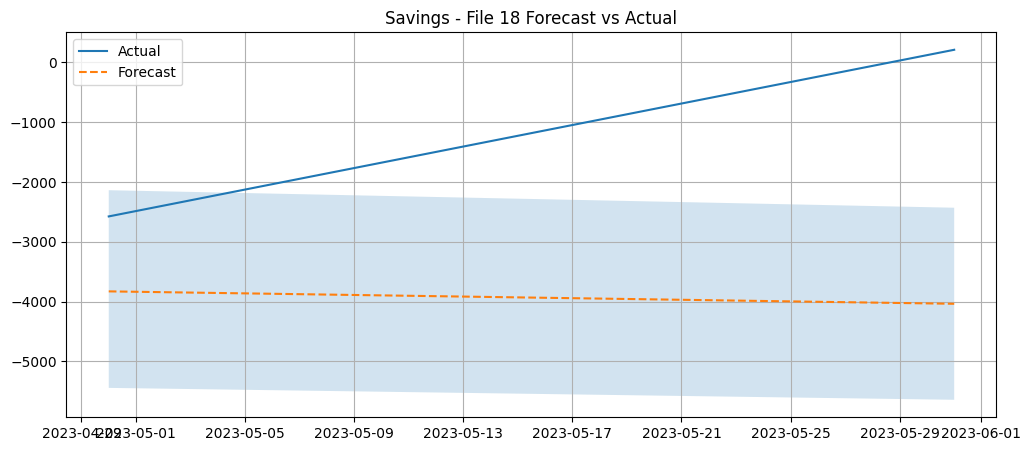

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/i47e58sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/dpy8uuna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99446', 'data', 'file=/tmp/tmprdqotoif/i47e58sg.json', 'init=/tmp/tmprdqotoif/dpy8uuna.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelupr6m2j0/prophet_model-20250703134843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:43 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 3269.10
MAE: 3265.21
MAPE: 71.11%


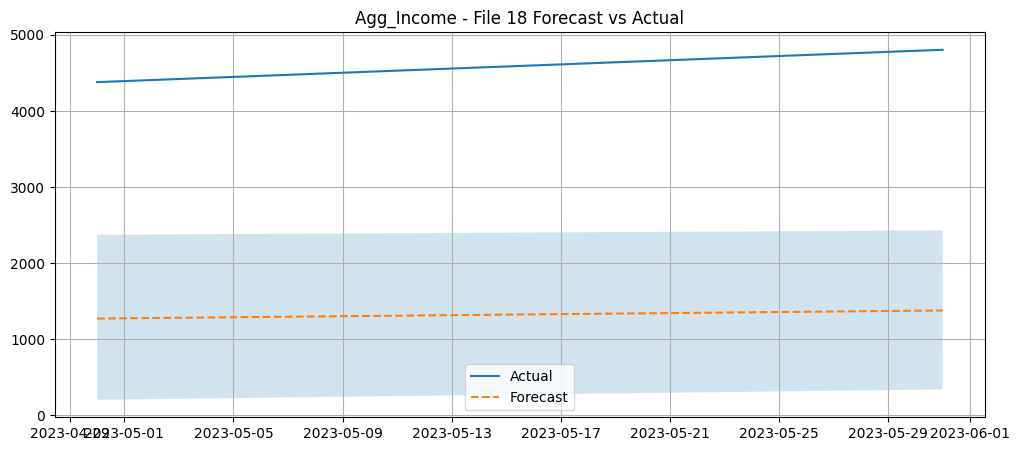

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/8n70pet2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/othk7taw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42820', 'data', 'file=/tmp/tmprdqotoif/8n70pet2.json', 'init=/tmp/tmprdqotoif/othk7taw.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model1m_ty080/prophet_model-20250703134843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:43 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 7182.31
MAE: 7160.86
MAPE: 29.64%


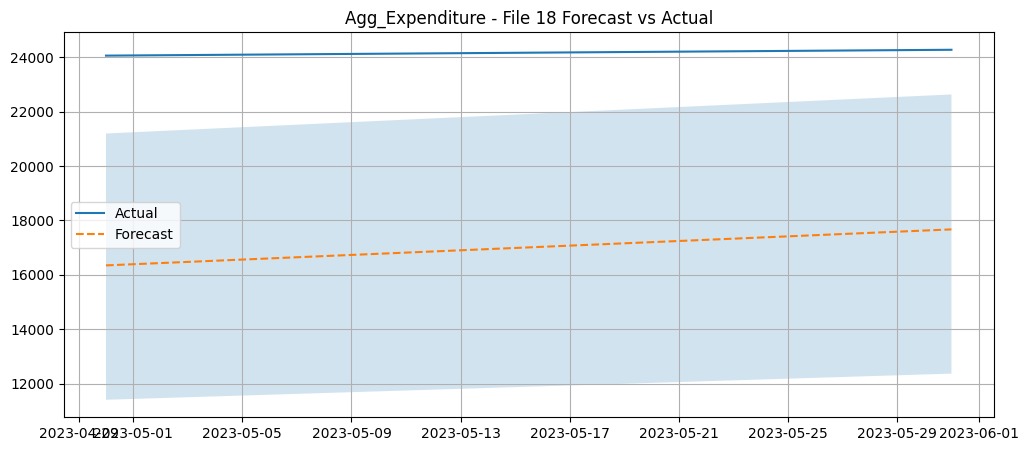

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/519v1g60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/1de9m4e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy

⚠️ Only one class present in training set. Skipping classification.


📄 Processing File 19/30: Bank of Baroda - S2.csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 20/30: KMB - S3.csv


13:48:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 1924.49
MAE: 1795.75
MAPE: 484.76%


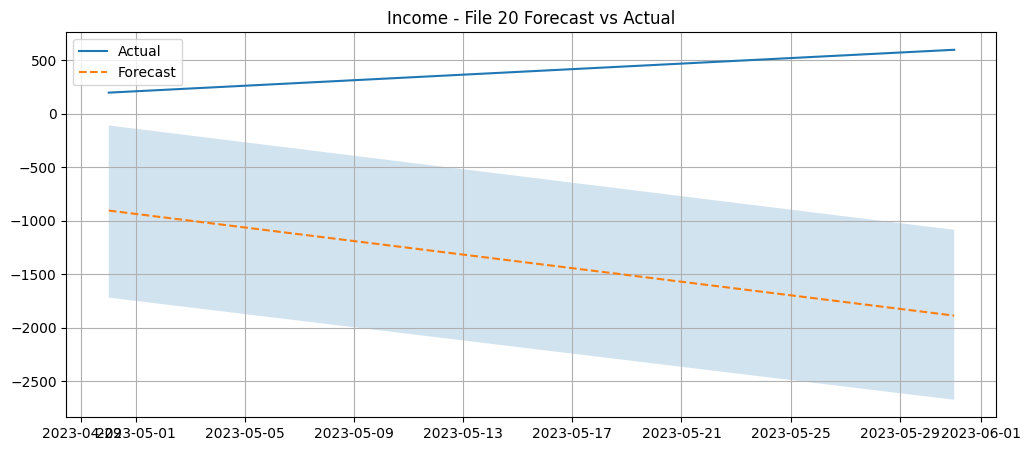

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/aaj6bxbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/91xu9hdw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6567', 'data', 'file=/tmp/tmprdqotoif/aaj6bxbn.json', 'init=/tmp/tmprdqotoif/91xu9hdw.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelhlsqlmnr/prophet_model-20250703134845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:45 - cmdstanpy - INFO - Chain [1] start processing
INF

Expenditure Forecast Evaluation:
RMSE: 5083.34
MAE: 4919.59
MAPE: 945.23%


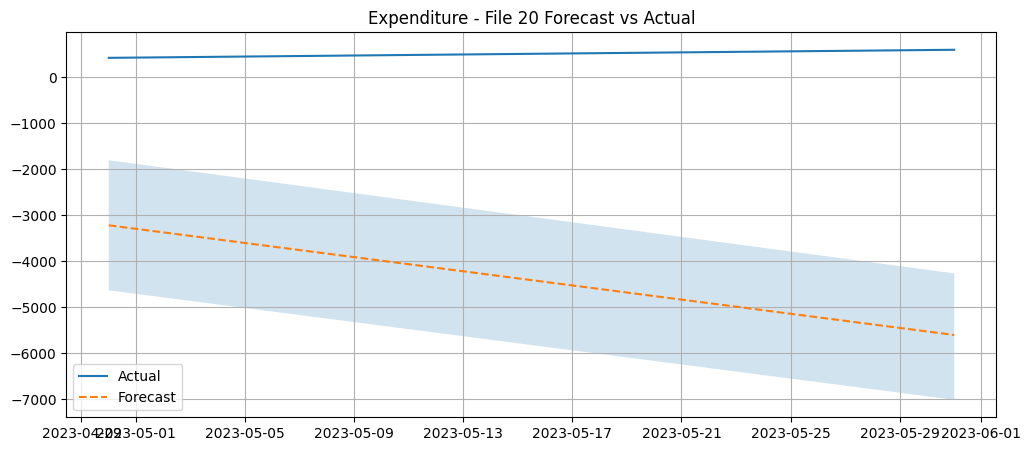

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/jr2gyzos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/h70aaepv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89726', 'data', 'file=/tmp/tmprdqotoif/jr2gyzos.json', 'init=/tmp/tmprdqotoif/h70aaepv.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model8bjdgtm1/prophet_model-20250703134845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:45 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 3171.96
MAE: 3117.21
MAPE: inf%


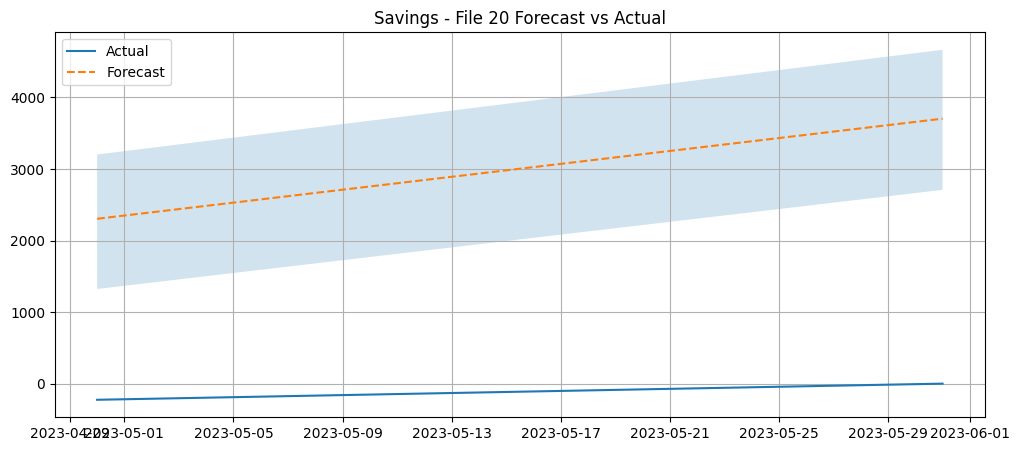

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/goqk_w26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/xba4iqvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7614', 'data', 'file=/tmp/tmprdqotoif/goqk_w26.json', 'init=/tmp/tmprdqotoif/xba4iqvh.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelwhc04fsr/prophet_model-20250703134846.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:46 - cmdstanpy - INFO - Chain [1] start processing
INF

Agg_Income Forecast Evaluation:
RMSE: 2456.31
MAE: 2419.84
MAPE: 23.44%


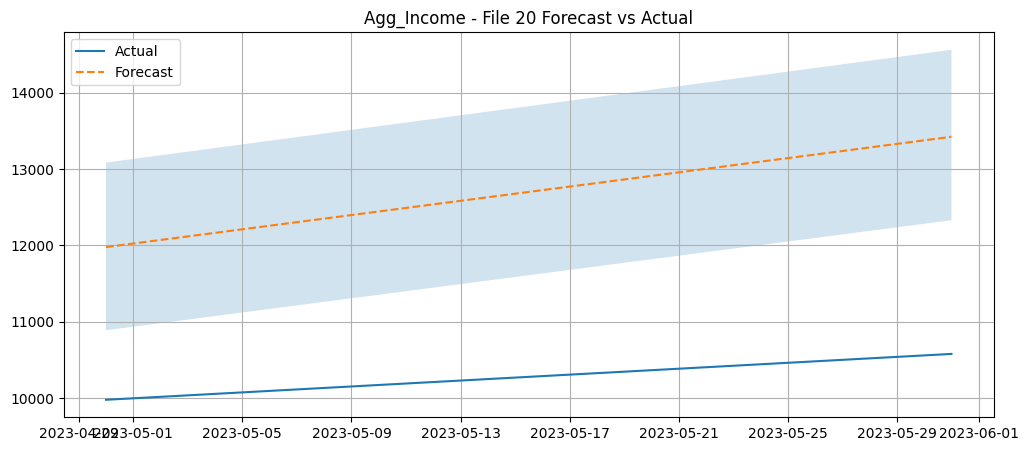

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/09w11eht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/yr03eary.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86920', 'data', 'file=/tmp/tmprdqotoif/09w11eht.json', 'init=/tmp/tmprdqotoif/yr03eary.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model_zil79i9/prophet_model-20250703134847.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 4202.93
MAE: 4121.33
MAPE: 21.25%


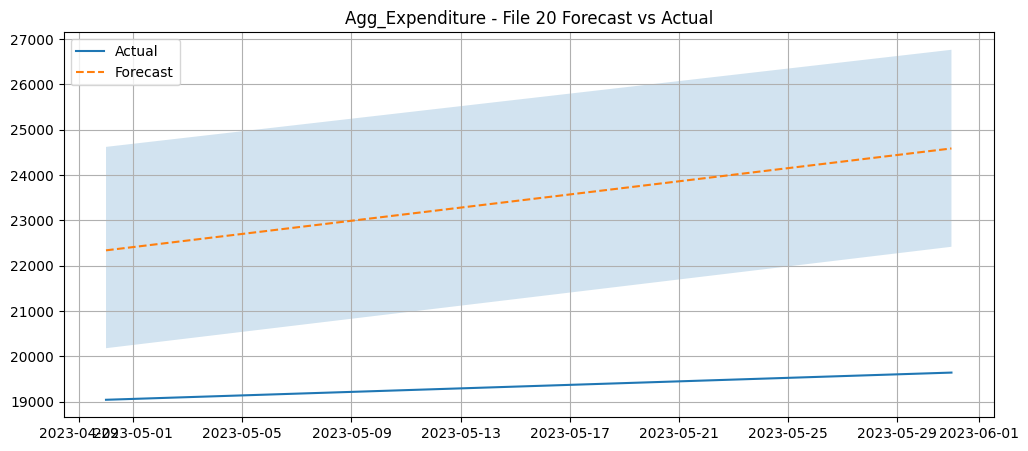

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


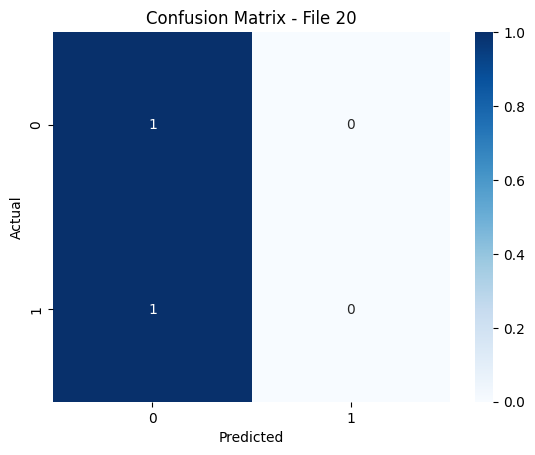

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-5-3484043052.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to overr



📄 Processing File 21/30: PNB - S1.csv
❌ Skipped (too few rows).


📄 Processing File 22/30: ICICI Bank - S2.csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 23/30: UBI - S3.csv
❌ Skipped (too few rows).


📄 Processing File 24/30: SBI - S3.csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 25/30: PNB - S2.csv


13:48:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 66587.61
MAE: 47121.12
MAPE: 17.24%


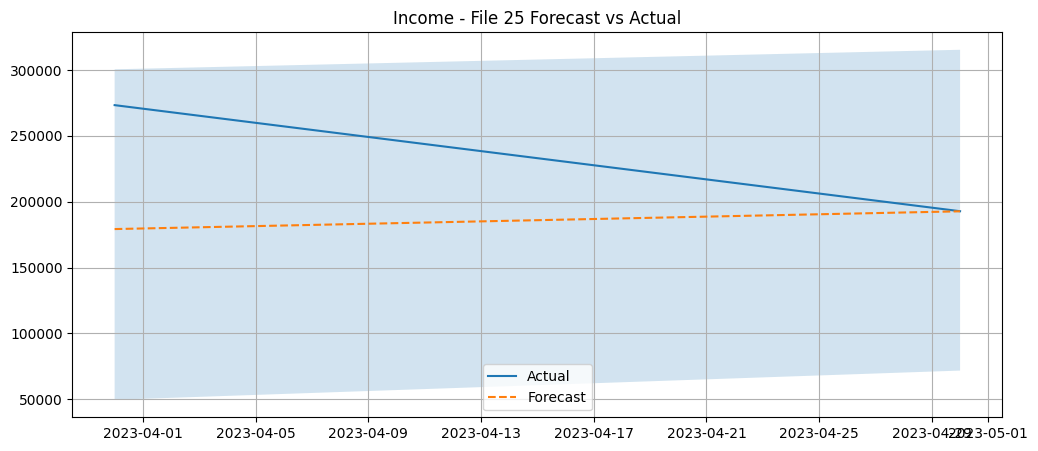

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/g1wref0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ozw3xd4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19553', 'data', 'file=/tmp/tmprdqotoif/g1wref0y.json', 'init=/tmp/tmprdqotoif/ozw3xd4_.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model4krzjo1t/prophet_model-20250703134849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 65793.44
MAE: 65680.72
MAPE: 37.43%


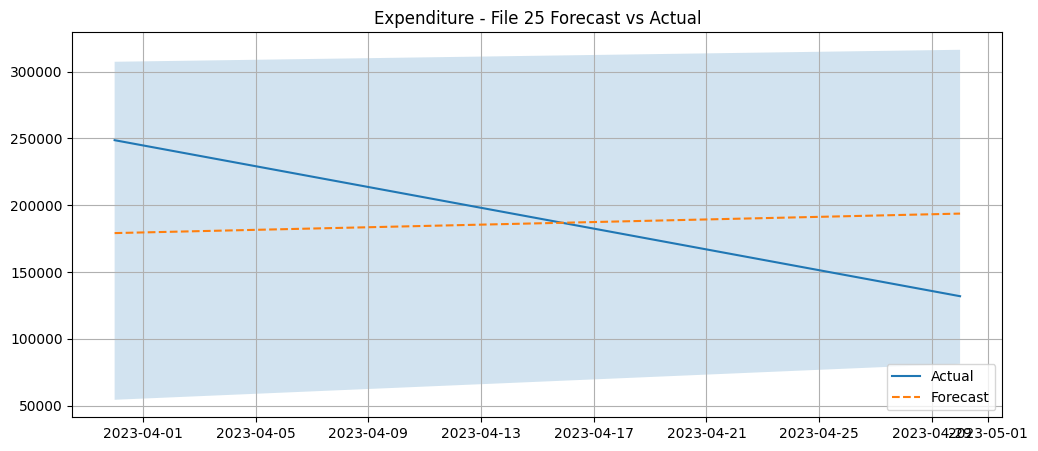

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/3npehujg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/5z_55sal.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99560', 'data', 'file=/tmp/tmprdqotoif/3npehujg.json', 'init=/tmp/tmprdqotoif/5z_55sal.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model1_2ibxqo/prophet_model-20250703134849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 47006.20
MAE: 43163.75
MAPE: 100.35%


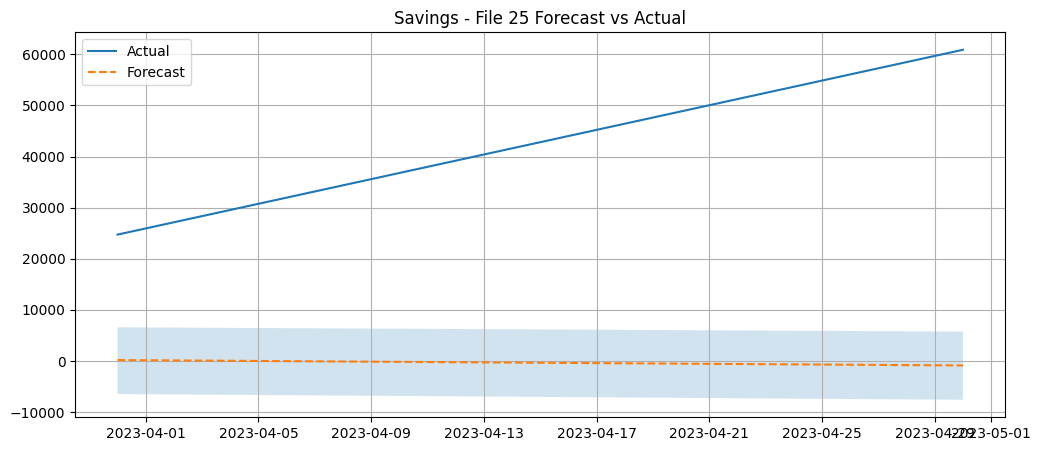

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/naxdxw37.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/x84bae87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63882', 'data', 'file=/tmp/tmprdqotoif/naxdxw37.json', 'init=/tmp/tmprdqotoif/x84bae87.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelz014bzl_/prophet_model-20250703134850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:50 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 56588.43
MAE: 56329.96
MAPE: 5.92%


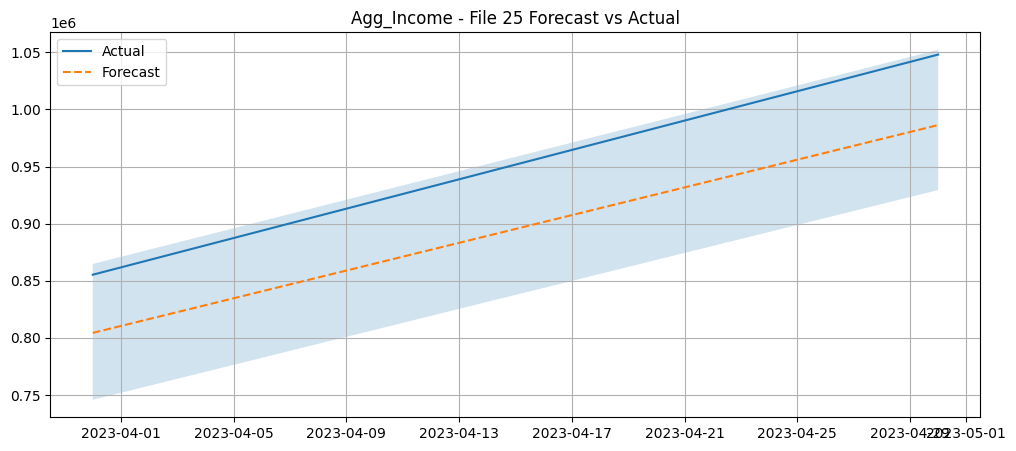

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/lpu_5gxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/7wpp99vp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65737', 'data', 'file=/tmp/tmprdqotoif/lpu_5gxf.json', 'init=/tmp/tmprdqotoif/7wpp99vp.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modellujk8z9m/prophet_model-20250703134850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:50 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 24486.11
MAE: 23782.15
MAPE: 2.75%


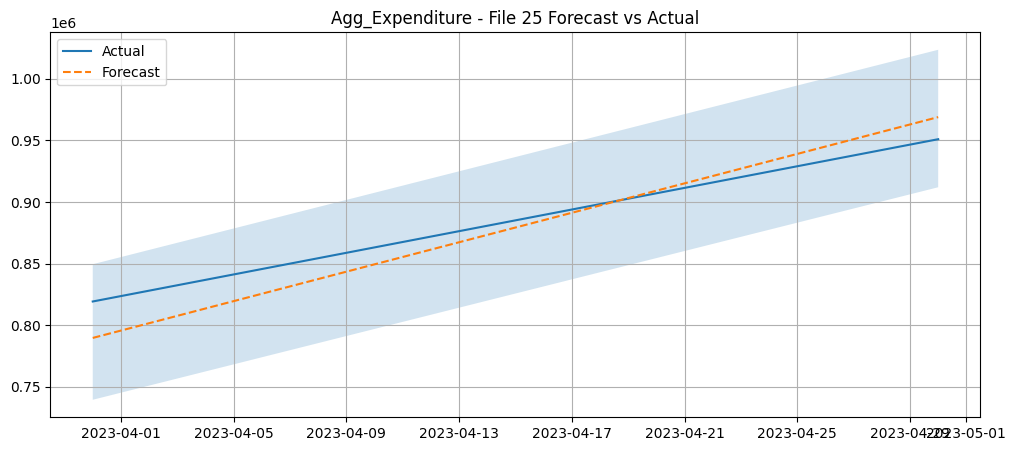

Classification Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


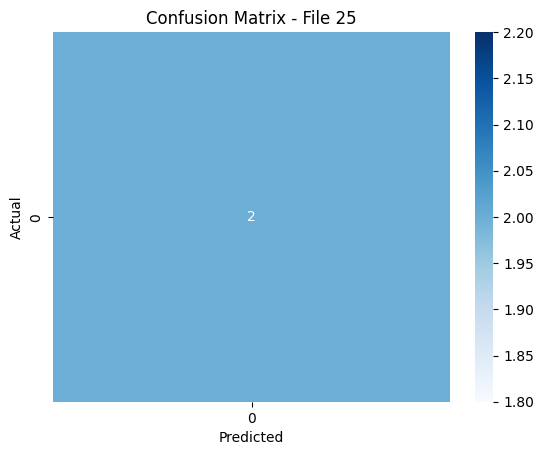

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/q6wdd1lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/jwwr20xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88379', 'data', 'file=/tmp/tmprdqotoif/q6wdd1lq.json', 'init=/tmp/tmprdqotoif/jwwr20xx.json'



📄 Processing File 26/30: UBI - S1.csv
Income Forecast Evaluation:
RMSE: 30741.07
MAE: 23309.49
MAPE: 107.48%


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


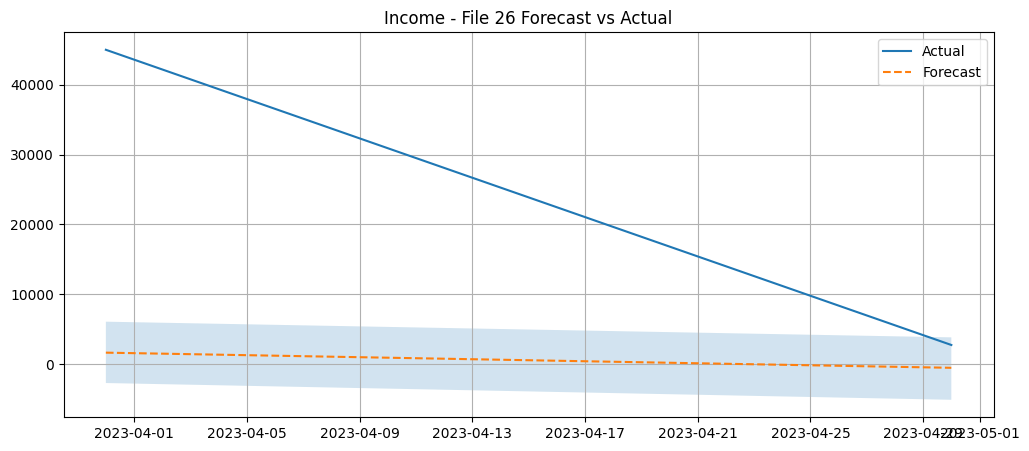

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/09zhpxia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/8os72y_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89766', 'data', 'file=/tmp/tmprdqotoif/09zhpxia.json', 'init=/tmp/tmprdqotoif/8os72y_s.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelytuj8ttp/prophet_model-20250703134851.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:51 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 31212.06
MAE: 24049.44
MAPE: 125.06%


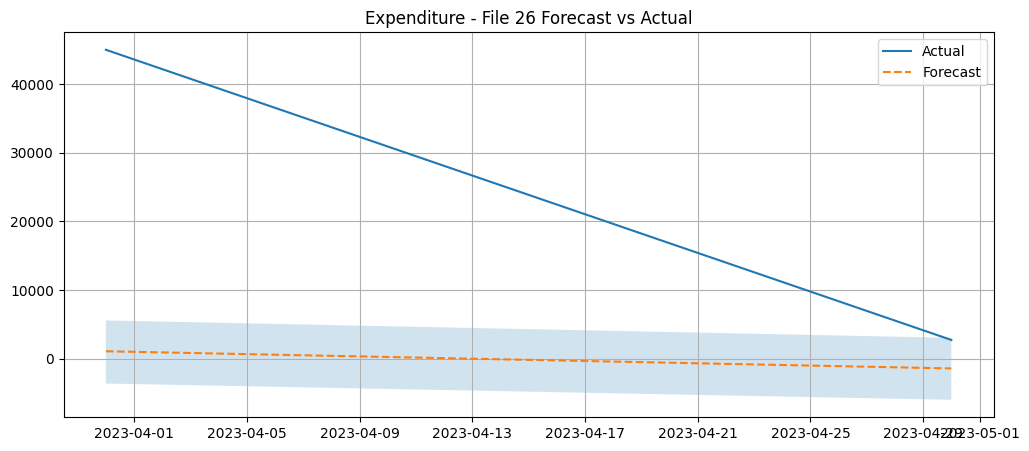

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/2qvy626r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/s2sdztq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96611', 'data', 'file=/tmp/tmprdqotoif/2qvy626r.json', 'init=/tmp/tmprdqotoif/s2sdztq7.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model1qn7wdxv/prophet_model-20250703134852.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:52 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 742.32
MAE: 727.96
MAPE: 3945.40%


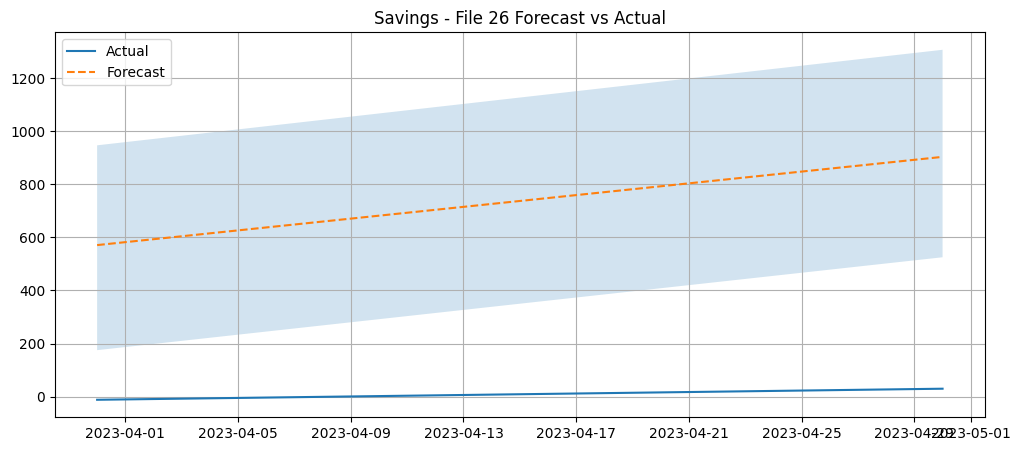

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/33aorzoj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/gum0lggg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52541', 'data', 'file=/tmp/tmprdqotoif/33aorzoj.json', 'init=/tmp/tmprdqotoif/gum0lggg.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model9te1k7zz/prophet_model-20250703134852.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:52 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 40611.06
MAE: 40600.74
MAPE: 54.32%


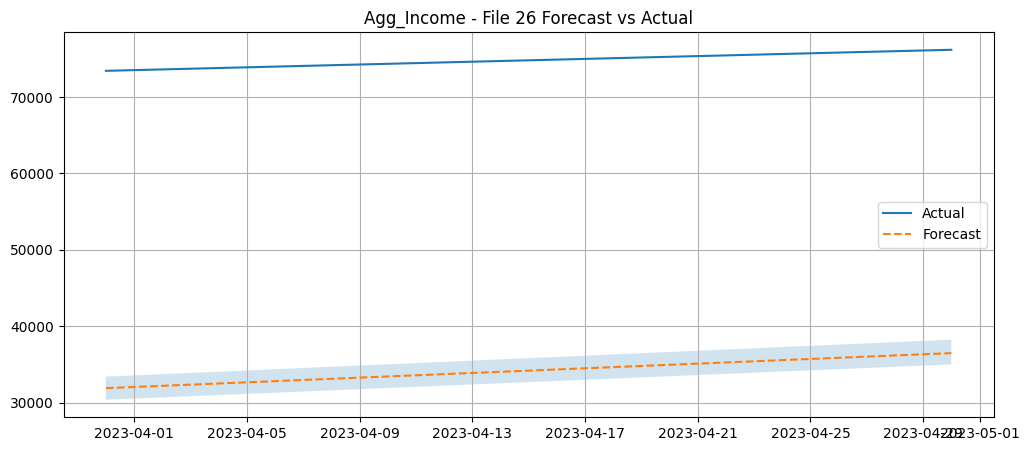

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/jd84g5fk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ek97yjwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78276', 'data', 'file=/tmp/tmprdqotoif/jd84g5fk.json', 'init=/tmp/tmprdqotoif/ek97yjwy.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model6gvg2gnd/prophet_model-20250703134853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:53 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 40626.59
MAE: 40616.09
MAPE: 53.59%


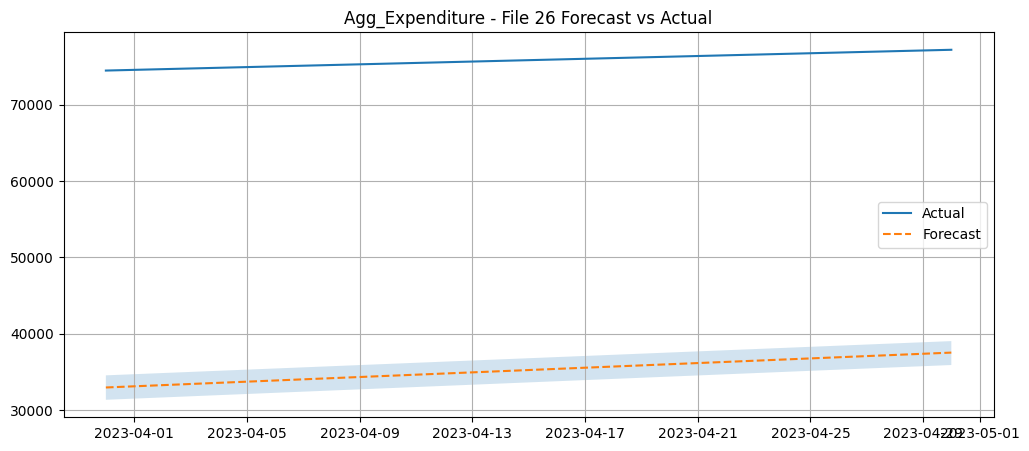

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



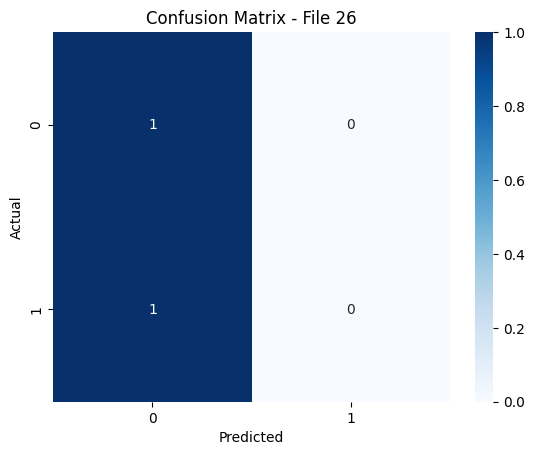

/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
/tmp/ipython-input-11-282301376.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/qjjzjb2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/wq2hevzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy



📄 Processing File 27/30: UBI - S2.csv
❌ Skipped (too few rows).


📄 Processing File 28/30: PNB - S3.csv
❌ Skipped (too few rows).


📄 Processing File 29/30: SBI - S1.csv
⚠️ Not enough months of data for forecasting. Skipping.


📄 Processing File 30/30: SBI - S2.csv


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Income Forecast Evaluation:
RMSE: 712.25
MAE: 602.68
MAPE: 11205.15%


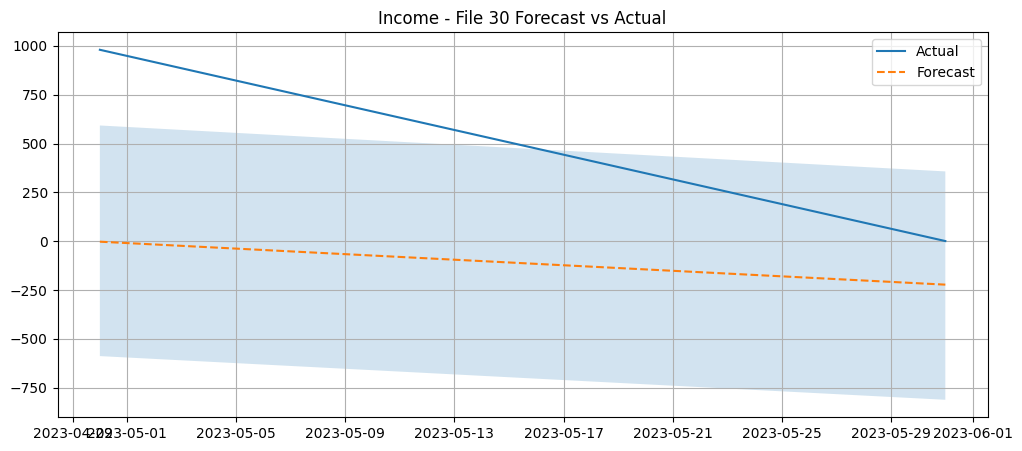

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ybl9kdbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/nv5_bc3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24345', 'data', 'file=/tmp/tmprdqotoif/ybl9kdbe.json', 'init=/tmp/tmprdqotoif/nv5_bc3r.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model79ei9h3v/prophet_model-20250703134854.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:54 - cmdstanpy - INFO - Chain [1] start processing
IN

Expenditure Forecast Evaluation:
RMSE: 1710.41
MAE: 1528.22
MAPE: 114847.62%


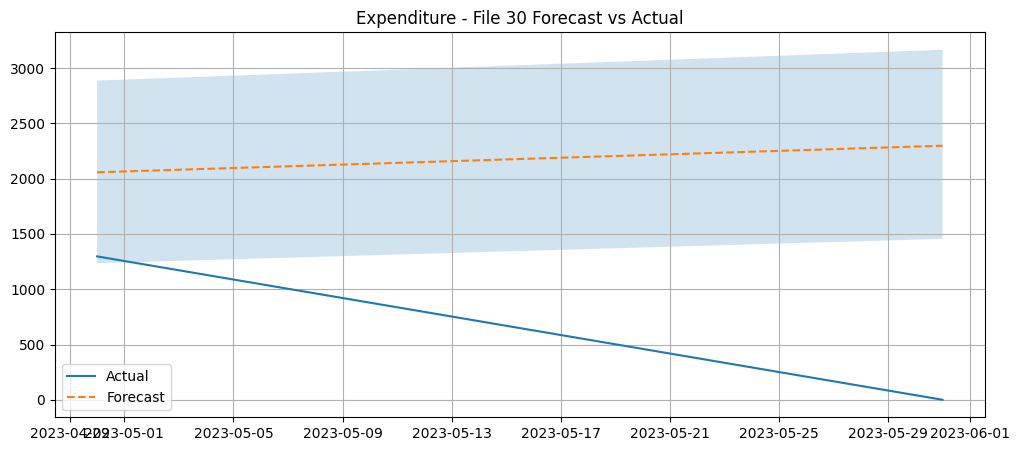

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/t1spnwej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/2wcjg_k5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49796', 'data', 'file=/tmp/tmprdqotoif/t1spnwej.json', 'init=/tmp/tmprdqotoif/2wcjg_k5.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model3xutheyr/prophet_model-20250703134855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:55 - cmdstanpy - INFO - Chain [1] start processing
IN

Savings Forecast Evaluation:
RMSE: 2179.62
MAE: 2144.56
MAPE: inf%


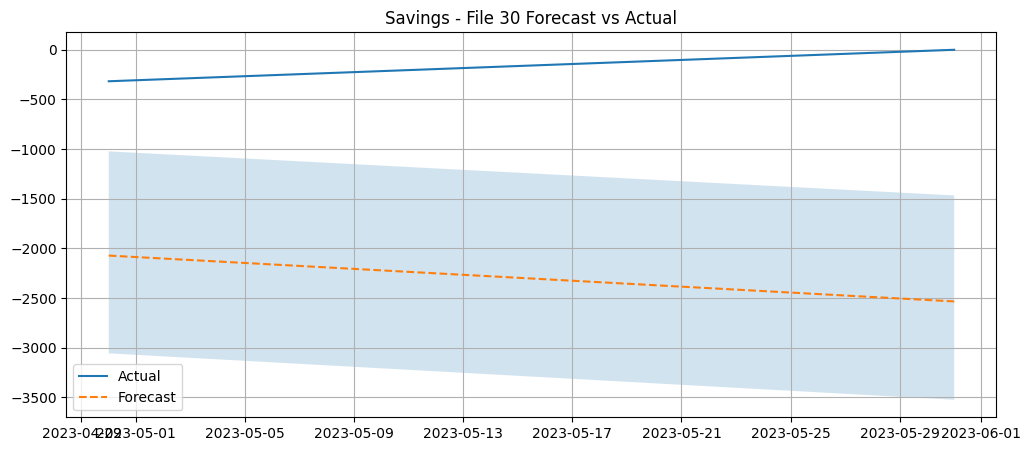

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/6tz45dij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/b38f8co_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18305', 'data', 'file=/tmp/tmprdqotoif/6tz45dij.json', 'init=/tmp/tmprdqotoif/b38f8co_.json', 'output', 'file=/tmp/tmprdqotoif/prophet_model4frcx298/prophet_model-20250703134855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:55 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Income Forecast Evaluation:
RMSE: 609.83
MAE: 506.49
MAPE: 12.15%


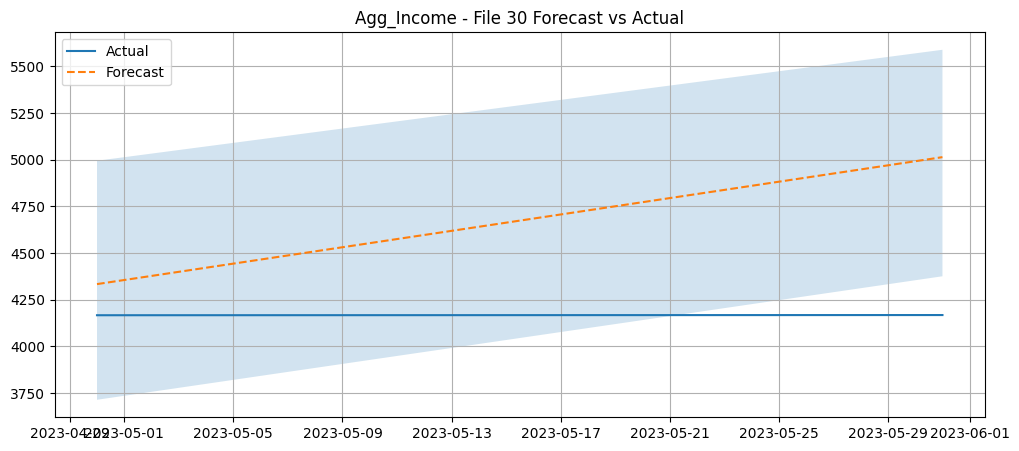

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/qhhv9n4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdqotoif/ie6a18kj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99811', 'data', 'file=/tmp/tmprdqotoif/qhhv9n4y.json', 'init=/tmp/tmprdqotoif/ie6a18kj.json', 'output', 'file=/tmp/tmprdqotoif/prophet_modelqn0v5s81/prophet_model-20250703134856.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:48:56 - cmdstanpy - INFO - Chain [1] start processing
IN

Agg_Expenditure Forecast Evaluation:
RMSE: 1702.58
MAE: 1461.01
MAPE: 17.97%


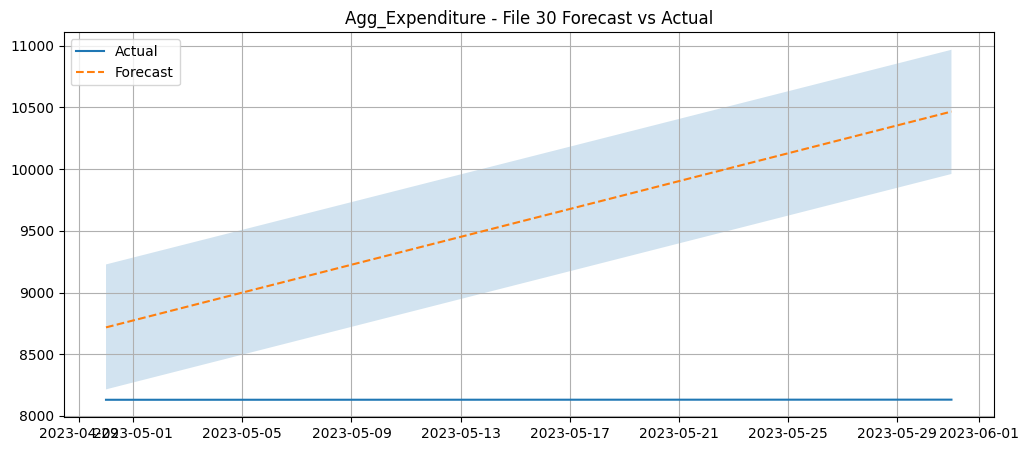

Classification Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


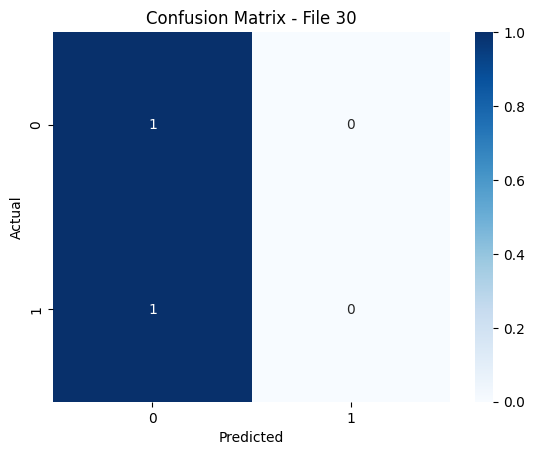

In [ ]:
# ✅ CELL 4: Loop Through Each Dataset
for idx, file in enumerate(csv_files):
    print(f"\n\n📄 Processing File {idx+1}/{len(csv_files)}: {os.path.basename(file)}")

    df = preprocess_bank_statement(file)
    if df.shape[0] < 10:
        print("❌ Skipped (too few rows).")
        continue

    # Monthly aggregation
    monthly_df = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
        'Income': 'sum',
        'Expenditure': 'sum',
        'Savings': 'sum',
        'Amount': ['count', 'mean', 'std'],
        'Days_Since_Last': 'mean'
    }).reset_index()

    monthly_df.columns = ['Date', 'Income', 'Expenditure', 'Savings',
                          'Transaction_Count', 'Avg_Transaction', 'Volatility', 'Avg_Gap']

    monthly_df['Agg_Income'] = monthly_df['Income'].cumsum()
    monthly_df['Agg_Expenditure'] = monthly_df['Expenditure'].cumsum()
    monthly_df['Month'] = monthly_df['Date'].dt.month
    monthly_df['Month_sin'] = np.sin(2 * np.pi * monthly_df['Month'] / 12)
    monthly_df['Month_cos'] = np.cos(2 * np.pi * monthly_df['Month'] / 12)
    monthly_df = monthly_df.dropna()

    if monthly_df.shape[0] < 6:
        print("⚠️ Not enough months of data for forecasting. Skipping.")
        continue

    # Forecasting
    for col in ['Income', 'Expenditure', 'Savings', 'Agg_Income', 'Agg_Expenditure']:
        model, forecast = forecast_with_split(monthly_df, col)
        if forecast is not None:
            evaluate_forecast_df(forecast, col)
            plot_forecast_df(forecast, f'{col} - File {idx+1}')
        else:
            print(f"⚠️ Skipped {col} forecast (not enough data).")

    # Classification
    monthly_df['Risk'] = (monthly_df['Savings'] < 0).astype(int)
    features = monthly_df[['Income', 'Expenditure', 'Savings', 'Agg_Income', 'Agg_Expenditure', 'Volatility', 'Avg_Gap']]
    labels = monthly_df['Risk']

    if labels.nunique() < 2 or len(labels) < 5:
        print("❗ Not enough variation in risk labels or data for classification.")
        continue

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, shuffle=False)

    if len(np.unique(y_train)) < 2:
      print("⚠️ Only one class present in training set. Skipping classification.")
      continue

    clf = LogisticRegression()
    clf.fit(X_train, y_train)


    print("Classification Accuracy:", clf.score(X_test, y_test))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - File {idx+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()